In [1]:

import jax
import jax.numpy as jnp
import numpy as np
from stljax.formula import *
from stljax.viz import *
import matplotlib.pyplot as plt
import equinox as eqx
from typing import Callable
import stljax
from jax import random

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from stljax.utils import smooth_mask, anneal


from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

/Users/karen/venvs/test/lib/python3.12/site-packages/equinox/internal/_noinline.py:379: DeprecationWarning: jax.core.pp_eqn_rules is deprecated.
  jax.core.pp_eqn_rules[noinline_p] = _noinline_pretty_print


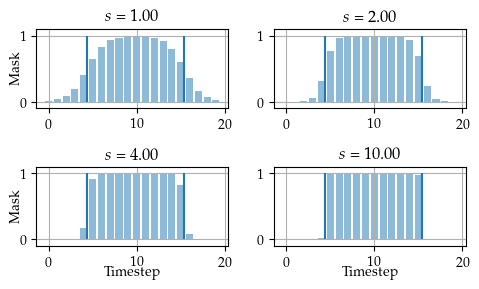

In [2]:
T = 20
plt.figure(figsize=(5,3))
a = 0.22
b = 0.77
for (i,s) in enumerate([1., 2., 4, 10]):
    plt.subplot(2,2,i+1)
    plt.bar(range(T), smooth_mask(T, a, b, s), alpha=0.5)
    plt.vlines([a*T, b*T], 0, 1)
    plt.grid()
    plt.ylim([-0.1, 1.1])
    plt.title("$s$ = %.2f"%s)
    if i in [2, 3]:
        plt.xlabel("Timestep",labelpad=-3)
    if i in [0,2]:
        plt.ylabel("Mask",labelpad=-3)
plt.tight_layout()
# plt.savefig("figs/smooth_mask.png", dpi=200, transparent=True)

In [3]:
key = random.key(1701)


In [4]:
class DifferentiableAlways2(STL_Formula):
    def __init__(self, subformula, interval=None):
        super().__init__()

        self.interval = interval
        self.subformula = subformula
        self._interval = [0, jnp.inf] if self.interval is None else self.interval

    def robustness_trace(self, signal, t_start, t_end, scale=1.0, padding="last", large_number=1E9, delta=1E-3, **kwargs):
        time_dim = 0  # assuming signal is [time_dim,...]
        signal = self.subformula(signal, padding=padding, large_number=large_number, **kwargs)
        T = signal.shape[time_dim]
        mask_value = large_number
        if self.interval is None:
            interval = [0,T-1]
        else:
            interval = self.interval
        signal_matrix = signal.reshape([T,1]) @ jnp.ones([1,T])
        if padding == "last":
            pad_value = signal[-1]
        elif padding == "mean":
            pad_value = signal.mean(time_dim)
        else:
            pad_value = padding
        signal_pad = jnp.ones([interval[1]+1, T]) * pad_value
        signal_padded = jnp.concatenate([signal_matrix, signal_pad], axis=time_dim)
        smooth_time_mask = smooth_mask(T, t_start, t_end, scale)
        padded_smooth_time_mask = jnp.zeros([2 * T, T])
        for t in range(T):
            padded_smooth_time_mask = padded_smooth_time_mask.at[t:t+T,t].set(smooth_time_mask)
            
        masked_signal_matrix = jnp.where(padded_smooth_time_mask > delta, signal_padded * padded_smooth_time_mask, mask_value)
        return minish(masked_signal_matrix, axis=time_dim, keepdims=False, **kwargs)

    def _next_function(self):
        """ next function is the input subformula. For visualization purposes """
        return [self.subformula]

    def __str__(self):
        return "◻ " + str(self._interval) + "( " + str(self.subformula) + " )"

In [5]:
pred = Predicate('x', lambda x: x)
dp = DifferentiableAlways(pred > 0.)
rec = AlwaysRecurrent(pred > 0.)

p = Always(pred > 0.)

In [6]:
@functools.partial(jax.jit, static_argnames=("approx_method"))
def foo(signal, t_start, t_end, scale, approx_method="true", temperature=20., delta=1E-3):
    return dp.robustness(signal, t_start=t_start, t_end=t_end, scale=scale, approx_method=approx_method, temperature=temperature, delta=delta)

grad_foo = jax.jit(jax.grad(foo, [1, 2]))

@functools.partial(jax.jit, static_argnames=("approx_method"))
def loss(signal, t_start, t_end, scale, approx_method, temperature, coeff=0.05):
    rob_ = foo(signal, t_start, t_end, scale, approx_method, temperature)
    rob = jax.nn.relu(-jnp.where(t_start < (t_end - 0.05), rob_, jnp.nan))
    return rob + coeff * (t_start - t_end)

@functools.partial(jax.jit, static_argnames=("approx_method"))
def loss_batch(signals, t_start, t_end, scale, approx_method, temperature, coeff=0.05):
    return jax.vmap(loss, [0, None, None, None, None, None, None])(signals, t_start, t_end, scale, approx_method, temperature, coeff).mean()

grad_loss = jax.jit(jax.grad(loss, [1,2]), static_argnames=("approx_method"))
grad_loss_batch = jax.jit(jax.grad(loss_batch, [1,2]), static_argnames=("approx_method"))


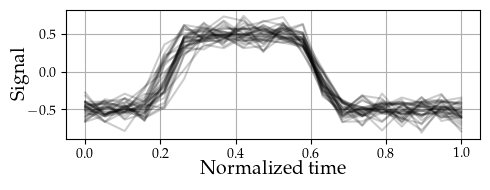

In [7]:
T = 20
fontsize = 14
true_t_start = 0.21
true_t_end = 0.59
bs = 32
signals = jax.vmap(smooth_mask, [None, 0, None, None])(T, true_t_start + 0.02 * random.normal(key, shape=(bs,)), true_t_end, 3.) + random.normal(key, shape=(bs, T,)) * 0.1 - 0.5
# signals = (smooth_mask(T, true_t_start, true_t_end, 200.) - 0.5) + random.normal(key, shape=(bs, T,)) * 0.1
plt.figure(figsize=(5,2))
# plt.subplot(1,2,1)
plt.plot(jnp.linspace(0,1,T), signals.T, color="black", alpha=0.2)
plt.xlabel("Normalized time", fontsize=fontsize, labelpad=-1)
plt.ylabel("Signal", fontsize=fontsize, labelpad=-1)

# plt.axis("equal")
plt.grid()

plt.tight_layout()

# plt.subplot(1,2,2)
# plt.plot(signals[0])
# # plt.axis("equal")
# plt.grid()

In [8]:
scale = 3.
temperature = 100.
approx_method = "true"
foo(signals[0], true_t_start, true_t_end, scale, approx_method="true", temperature=temperature)

Array(-0.02100803, dtype=float32)

In [9]:
def visualize_smooth_time_interval_(signal, t_start, t_end, scale, approx_method, temperature):
    fontsize = 14
    delta = 1E-3
    T = signal.shape[0]
    xs = jnp.linspace(0., 1., T)
    mask = smooth_mask(T, t_start, t_end, scale)
    plt.plot(signal, label="Signal")
    plt.plot(mask, label="Mask")
    ss = dp.subformula(signal)
    # jnp.where(padded_smooth_time_mask, signal_padded * padded_smooth_time_mask, mask_value)
    masked_signal = jnp.where(mask > delta, ss * mask, jnp.nan)
    plt.plot(masked_signal, "o-", label="Masked signal")

    rob = foo(signal, t_start=t_start, t_end=t_end, scale=scale, approx_method=approx_method, temperature=temperature)
    plt.hlines(rob, 0, T, color="red", label="Robustness")
    # plt.hlines(delta, 0, 1, color="green", label="Delta")
    
    
    if approx_method != "true":
        match approx_method:
            case "logsumexp":
                app = "LSE"
            case "softmax":
                app = "soft"
        plt.title("$\\rho$ = %.3f (s = %.2f, $\\tau_\\mathrm{%s}=$%.2f)"%(rob, scale, app, temperature))
    else:
        plt.title("$\\rho$ = %.3f (s = %.2f)"%(rob, scale))
        
    # plt.ylim([-1.5, 1.5])
    plt.grid(zorder=-5, alpha=0.2)
    plt.legend(ncol=2)
    plt.xlabel("Normalized time", fontsize=fontsize)
    plt.ylabel("Signal magnitude", fontsize=fontsize)

def visualize_smooth_time_interval(signal, t_start, t_end, scale, approx_method, temperature):
    plt.figure(figsize=(5,3))
    visualize_smooth_time_interval_(signal, t_start, t_end, scale, approx_method, temperature)


def visualize_loss_landscape(loss_func, signal, scale, approx_method, temperature, coeff):
    N = 100
    fontsize = 14
    levels = 10
    T = signal.shape[0]
    starts, ends = jnp.meshgrid(jnp.linspace(0,1, N), jnp.linspace(0,1, N))
    losses = jax.vmap(loss_func, [None, 0, 0, None, None, None, None])(signal, starts.reshape([-1,1]), ends.reshape([-1,1]), scale, approx_method, temperature, coeff).reshape([N,N])
    
    plt.contourf(starts, ends, losses, levels=levels, cmap="jet", alpha=0.4)
    plt.colorbar()
    if approx_method != "true":
        match approx_method:
            case "logsumexp":
                app = "LSE"
            case "softmax":
                app = "soft"
        plt.title("Loss landscape \n  (s = %.2f, $\\tau_\\mathrm{%s}$ = %.2f)"%(scale, app, temperature))
    else:
        plt.title("Loss landscape \n (s = %.2f)"%(scale))
    plt.xlabel("$t_\\mathrm{start}$", fontsize=fontsize)
    plt.ylabel("$t_\\mathrm{end}$", fontsize=fontsize)
    plt.grid(zorder=-5, alpha=0.2)


def visualize_gradients(i, grad_function, signal, scale, approx_method, temperature, coeff):
    N = 100
    levels = 10
    fontsize = 14
    starts, ends = jnp.meshgrid(jnp.linspace(0,1, N), jnp.linspace(0,1, N))
    
    da, db = jax.vmap(grad_function, [None, 0, 0, None, None, None, None])(signal, starts.reshape([-1]), ends.reshape([-1]), scale, approx_method, temperature, coeff)
    da = jnp.where(starts < (ends - 0.05), da.reshape([N,N]), jnp.nan)
    db = jnp.where(starts < (ends - 0.05), db.reshape([N,N]), jnp.nan)
    
    if i == 0:
        dd = da
    else:
        dd = db
    plt.contourf(starts, ends, jnp.abs(dd), levels=levels, alpha=0.4)
    plt.colorbar()
    
    if approx_method != "true":
        match approx_method:
            case "logsumexp":
                app = "LSE"
            case "softmax":
                app = "soft"
        plt.title("(s = %.2f, $\\tau_\\mathrm{%s}$ = %.2f)"%(scale, app, temperature))
    else:
        plt.title("(s = %.2f)"%(scale))
    plt.xlabel("$t_\\mathrm{start}$", fontsize=fontsize)
    plt.ylabel("$t_\\mathrm{end}$", fontsize=fontsize)
    plt.grid(zorder=-5, alpha=0.2)
    
    


In [10]:
approx_method = "true"
start_index_slider = widgets.FloatSlider(value=0.21, min=0.0, max=1., step=0.01, description='t_start: ')
end_index_slider = widgets.FloatSlider(value=0.59, min=0.0, max=1., step=0.01, description='t_end: ')
scale_index_slider = widgets.FloatSlider(value=1., min=1., max=50, step=1, description='scale: ')
temp_index_slider = widgets.FloatSlider(value=1., min=1., max=100, step=1, description='temperature: ')
delta_index_slider = widgets.FloatSlider(value=3, min=1., max=12, step=1, description='delta: ')

interact(visualize_smooth_time_interval, signal=widgets.fixed(signals[0]), 
                                         t_start=start_index_slider,
                                         t_end=end_index_slider,
                                         scale=scale_index_slider,
                                         approx_method=widgets.fixed(approx_method),
                                         temperature=temp_index_slider)

/Users/karen/venvs/test/lib/python3.12/site-packages/ipywidgets/widgets/interaction.py:43: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


interactive(children=(FloatSlider(value=0.21, description='t_start: ', max=1.0, step=0.01), FloatSlider(value=…

<function __main__.visualize_smooth_time_interval(signal, t_start, t_end, scale, approx_method, temperature)>

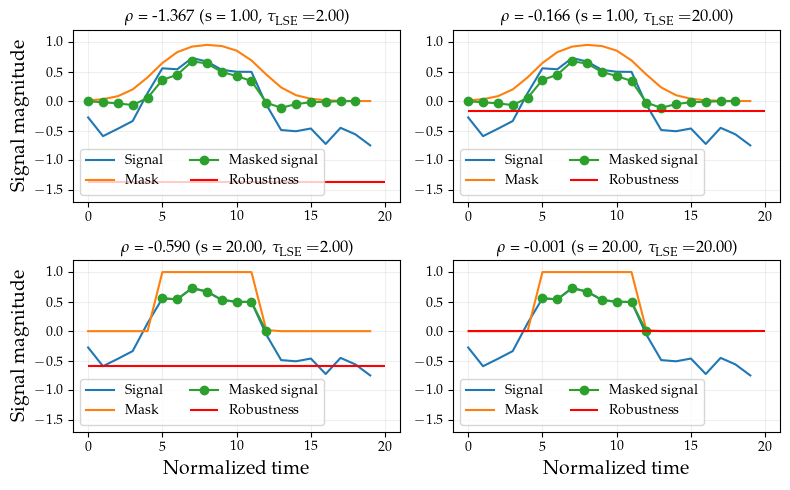

In [11]:
approx_method = "logsumexp"
plt.figure(figsize=(8,5))
scales = [1., 20.]
temps = [2., 20.]
i = 1
for s in scales:
    for t in temps:
        plt.subplot(2,2,i)
        visualize_smooth_time_interval_(signals[0], true_t_start+0.01, true_t_end, s, approx_method, t)
        plt.ylim([-1.7, 1.2])
        if i in [1,2]:
            plt.xlabel("")
        if i in [2,4]:
            plt.ylabel("")
        i += 1
plt.tight_layout()

In [12]:
def plot_loss_landscape(signal, s, e, scale, approx_method, temperature, coeff):
    N = 100
    ticks = jnp.linspace(0, 1, N)
    starts, ends = jnp.meshgrid(ticks, ticks)
    losses = jax.vmap(loss, [None, 0, 0, None, None, None, None])(signal, starts.reshape([-1,1]), ends.reshape([-1,1]), scale, approx_method, temperature, coeff).reshape([N,N])
    # s = starts[0,t_start_idx]
    # e = ends[t_end_idx, 0]
    ell = loss(signal, s, e, scale, approx_method, temperature, coeff)
    
    plt.figure(figsize=(18,3))
    
    plt.subplot(1,5,1)
    
    visualize_smooth_time_interval_(signal, s, e, scale, approx_method, temperature)
    
    plt.subplot(1,5,2)
    visualize_loss_landscape(loss, signal, scale, approx_method, temperature, coeff)
    plt.vlines(s, 0, 1, color="red")
    plt.hlines(e, 0, 1, color="blue")
    if approx_method != "true":
        plt.title("Loss landscape, $\\ell=$%.5f \n (s = %.2f, $\\tau$ = %.2f)"%(ell, scale, temperature))
    else:
        plt.title("Loss landscape, $\\ell=$%.5f \n (s = %.2f)"%(ell, scale))


    plt.subplot(2,5,3)
    plt.title("$t_\\mathrm{end}$=%.2f"%e)
    ls = jax.vmap(loss, [None, 0, None, None, None, None, None])(signal, ticks, e, scale, approx_method, temperature, coeff)
    plt.plot(ticks, ls, color="blue")
    plt.vlines(s, 0,0.1)
    plt.xlim([0,1])
    plt.grid()
    
    plt.subplot(2,5,8)
    plt.title("$t_\\mathrm{start}$=%.2f"%s)
    ls = jax.vmap(loss, [None, None, 0, None, None, None, None])(signal, s, ticks, scale, approx_method, temperature, coeff)
    plt.plot(ticks, ls, color="red")
    plt.vlines(e, 0,0.1)
    plt.xlim([0,1])
    plt.grid()
    
    # gradients
    a, b = grad_loss(signal, s, e, scale, approx_method, temperature)
    
    plt.subplot(1,5,4)
    visualize_gradients(0, grad_loss, signal, scale, approx_method, temperature, coeff)
    plt.vlines(s, 0, 1, color="red")
    plt.hlines(e, 0, 1, color="blue")
    if approx_method != "true":
        plt.title("$\\frac{\\partial\\ell}{\\partial t_\\mathrm{start}}$ = %.2f \n (s = %.2f, $\\tau$ = %.2f)"%(a, scale, temperature))
    else:
        plt.title("$\\frac{\\partial\\ell}{\\partial t_\\mathrm{start}}$ = %.2f \n (s = %.2f)"%(a, scale))
    
    plt.subplot(1,5,5)
    visualize_gradients(1, grad_loss, signal, scale, approx_method, temperature, coeff)
    plt.vlines(s, 0, 1, color="red")
    plt.hlines(e, 0, 1, color="blue")
    if approx_method != "true":
        plt.title("$\\frac{\\partial\\ell}{\\partial t_\\mathrm{end}}$ = %.2f \n (s = %.2f, $\\tau$ = %.2f)"%(b, scale, temperature))
    else:
        plt.title("$\\frac{\\partial\\ell}{\\partial t_\\mathrm{end}}$ = %.2f \n (s = %.2f)"%(b, scale))
    
    plt.tight_layout()



start_index_slider = widgets.FloatSlider(value=0.21, min=0.0, max=1., step=0.01, description='t_start: ')
end_index_slider = widgets.FloatSlider(value=0.59, min=0.0, max=1., step=0.01, description='t_end: ')
scale_index_slider = widgets.FloatSlider(value=1., min=.1, max=10, step=.5, description='scale: ')
temp_index_slider = widgets.FloatSlider(value=1., min=.1, max=10, step=.5, description='temperature: ')
delta_index_slider = widgets.FloatSlider(value=3, min=1., max=12, step=1, description='delta: ')

# start_index_slider = widgets.IntSlider(value=23, min=0, max=99, step=1, description='t_start: ')
# end_index_slider = widgets.IntSlider(value=58, min=0, max=99, step=1, description='t_end: ')
coeff_slider = widgets.FloatSlider(value=0.01, min=0., max=1., step=0.02, description='coeff: ')
approx_method_slider = widgets.Dropdown(
    options=['true', "logsumexp", "softmax"],
    value='true',
    description='approx method:',
    disabled=False,
)
interact(plot_loss_landscape, signal=widgets.fixed(signals[0]), 
                              s=start_index_slider,
                              e=end_index_slider,
                              scale=scale_index_slider,
                              approx_method=approx_method_slider,
                              temperature=temp_index_slider,
                              coeff=coeff_slider)


interactive(children=(FloatSlider(value=0.21, description='t_start: ', max=1.0, step=0.01), FloatSlider(value=…

<function __main__.plot_loss_landscape(signal, s, e, scale, approx_method, temperature, coeff)>

In [13]:
approx_method = "logsumexp"
temperature = 1.
scale = 1.
a = -2.
b = 2.
lr = 1E-2
max_steps = 5000
scale_start = 1.
scale_end = 20
temperature_start = 1.
temperature_end = 20
a_list = [a]
b_list = [b]
coeff_start = 0.1
coeff_end = 0.


for i in range(max_steps):
    j = (i / max_steps)
    s = (1 - j) * scale_start + j * scale_end
    t = (1 - j) * temperature_start + j * temperature_end
    c = (1 - j) * coeff_start + j * coeff_end
    a_ = jax.nn.sigmoid(a)
    b_ = jax.nn.sigmoid(b)
    g = grad_loss_batch(signals, a_, b_, s, approx_method, t, c)
    a -= lr * g[0] * a_ * (1 - a_)
    b -= lr * g[1] * b_ * (1 - b_)
    a_list.append(a)
    b_list.append(b)
    # print(a,b)
a_list = jnp.stack(a_list)
b_list = jnp.stack(b_list)

In [14]:
%timeit grad_loss_batch(signals, a_, b_, s, approx_method, t, c)

94 μs ± 369 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [15]:
coeff = 0.0
def visualize_results(i):
    a, b = jax.nn.sigmoid(a_list[i]), jax.nn.sigmoid(b_list[i])
    j = (i / max_steps)
    s = (1 - j) * scale_start + j * scale_end
    t = (1 - j) * temperature_start + j * temperature_end
    c = (1 - j) * coeff_start + j * coeff_end
    plot_loss_landscape(signals[0], a, b, s, approx_method, t, c)
    
index_slider = widgets.IntSlider(value=0, min=0, max=max_steps-1, step=250, description='i: ')
interact(visualize_results, i=index_slider)

interactive(children=(IntSlider(value=0, description='i: ', max=4999, step=250), Output()), _dom_classes=('wid…

<function __main__.visualize_results(i)>

In [16]:
step_size = 50
def visualize_results(i, approx_method):
    a, b = jax.nn.sigmoid(a_list[i]), jax.nn.sigmoid(b_list[i])
    j = (i / max_steps)
    s = (1 - j) * scale_start + j * scale_end
    t = (1 - j) * temperature_start + j * temperature_end
    ell = loss_batch(signals, a, b, s, approx_method, t, coeff)
    
    # plt.figure(figsize=(4,3))
    
    visualize_loss_landscape(loss_batch, signals, s, approx_method, t, coeff)
    plt.plot(jax.nn.sigmoid(a_list[::step_size]), jax.nn.sigmoid(b_list[::step_size]), "o-", markersize=3, color="black", linewidth=1)
    current_loss = loss_batch(signals, a, b, s, approx_method, t, coeff)
    gt_loss = loss_batch(signals, true_t_start, true_t_end, s, approx_method, t, coeff)
    plt.scatter([a], [b], marker="o", s=40, color="magenta", label="Current: %.3f"%current_loss, edgecolor="black", zorder=4)
    plt.scatter([true_t_start], [true_t_end], marker="*", s=100, color="orange", label="Ground truth: %.3f"%gt_loss, edgecolor="black", zorder=4)
    

    plt.vlines(a, 0, 1, color="red", linestyle='--')
    plt.hlines(b, 0, 1, color="blue", linestyle='--')
    if approx_method != "true":
        match approx_method:
            case "logsumexp":
                app = "LSE"
            case "softmax":
                app = "soft"
        plt.title("Loss = %.5f (s = %.2f, $\\tau_\\mathrm{%s}$ = %.2f)"%(ell, s, app, t))
    else:
        plt.title("Loss = %.5f (s = %.2f)"%(ell, s))
    plt.legend(loc="lower right")
index_slider = widgets.IntSlider(value=0, min=0, max=max_steps-1, step=step_size, description='i: ')
interact(visualize_results, i=index_slider, approx_method=widgets.fixed(approx_method))



interactive(children=(IntSlider(value=0, description='i: ', max=4999, step=50), Output()), _dom_classes=('widg…

<function __main__.visualize_results(i, approx_method)>

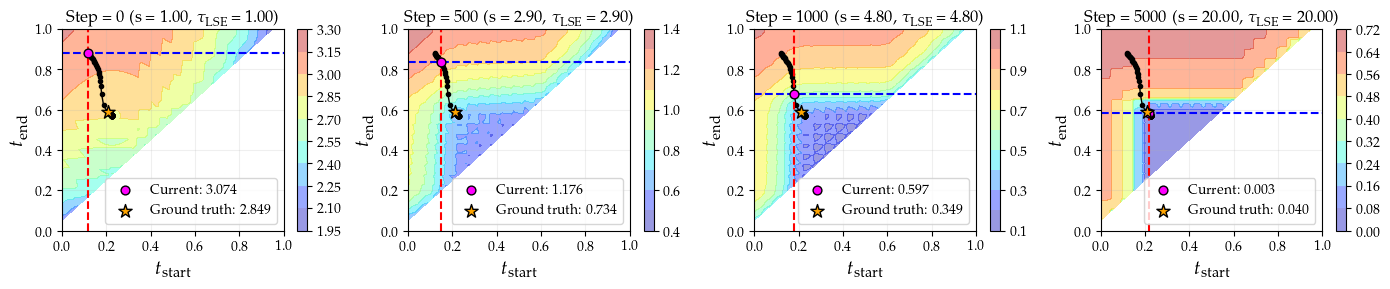

In [17]:
plt.figure(figsize=(14,3))
for (i,k) in enumerate([0, 500, 1000, 5000]):
    plt.subplot(1,4,i+1)
    visualize_results(k, approx_method)
    j = (k / max_steps)
    s = (1 - j) * scale_start + j * scale_end
    t = (1 - j) * temperature_start + j * temperature_end
    if approx_method != "true":
        match approx_method:
            case "logsumexp":
                app = "LSE"
            case "softmax":
                app = "soft"
        plt.title("Step = %i (s = %.2f, $\\tau_\\mathrm{%s}$ = %.2f)"%(k, s, app, t))
    else:
        plt.title("Step = %i (s = %.2f)"%(k, s))
    plt.tight_layout()
    # plt.savefig("figs/gradient_descent_panel_LSE", dpi=200, transparent=True)

In [18]:
# brute force search
N = 300
scale = 200.
approx_method = "true"
temperature = 40.
coeff = 0.05

starts, ends = jnp.meshgrid(jnp.linspace(0,1, N), jnp.linspace(0,1, N))
n = jnp.nanargmin(jax.vmap(loss_batch, [None, 0, 0, None, None, None])(signals, starts.reshape([-1]), ends.reshape([-1]), scale, approx_method, temperature))
t_start, t_end = starts.reshape([-1])[n], ends.reshape([-1])[n]
# poo(signals[0], t_start, t_end, scale, approx_method, temperature)

In [19]:
%timeit jnp.nanargmin(jax.vmap(loss_batch, [None, 0, 0, None, None, None])(signals, starts.reshape([-1]), ends.reshape([-1]), scale, approx_method, temperature))

2.6 s ± 221 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [499]:
loss_batch(signals, t_start, t_end, scale, approx_method, temperature, 0.), loss_batch(signals, true_t_start, true_t_end, scale, approx_method, temperature, 0.)

(Array(0.00010173, dtype=float32), Array(0.00298509, dtype=float32))

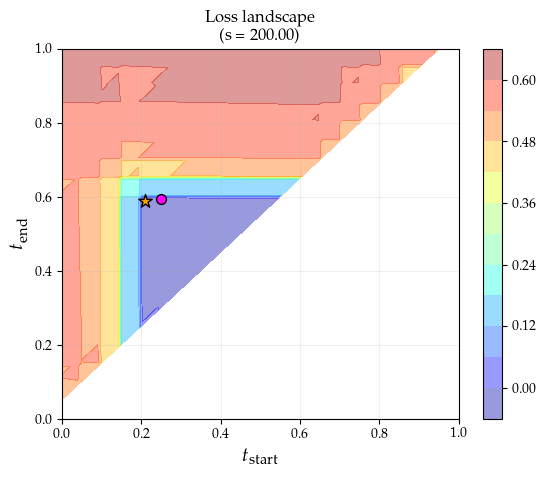

In [500]:
visualize_loss_landscape(loss_batch, signals, scale, approx_method, temperature, coeff)
# plt.plot(jax.nn.sigmoid(a_list[::step_size]), jax.nn.sigmoid(b_list[::step_size]), "o-", markersize=3, color="black", linewidth=1)
plt.scatter([t_start], [t_end], marker="o", s=50, color="magenta", label="Current", edgecolor="black", zorder=4)
plt.scatter([true_t_start], [true_t_end], marker="*", s=100, color="orange", label="Ground truth", edgecolor="black", zorder=4)



In [501]:
def visualize_loss_landscape(loss_func, signal, scale, approx_method, temperature, coeff):
    N = 100
    fontsize = 14
    levels = 10
    T = signal.shape[0]
    starts, ends = jnp.meshgrid(jnp.linspace(0,1, N), jnp.linspace(0,1, N))
    losses = jax.vmap(loss_func, [None, 0, 0, None, None, None, None])(signal, starts.reshape([-1,1]), ends.reshape([-1,1]), scale, approx_method, temperature, coeff).reshape([N,N])
    
    plt.contourf(starts, ends, losses, levels=levels, cmap="jet", alpha=0.4)
    plt.colorbar()
    if approx_method != "true":
        match approx_method:
            case "logsumexp":
                app = "LSE"
            case "softmax":
                app = "soft"
        plt.title("s = %.2f, $\\tau_\\mathrm{%s}$ = %.2f"%(scale, app, temperature))
    else:
        plt.title("s = %.2f"%(scale))
    plt.xlabel("$t_\\mathrm{start}$", fontsize=fontsize, labelpad=-3)
    plt.ylabel("$t_\\mathrm{end}$", fontsize=fontsize)
    plt.grid(zorder=-5, alpha=0.2)

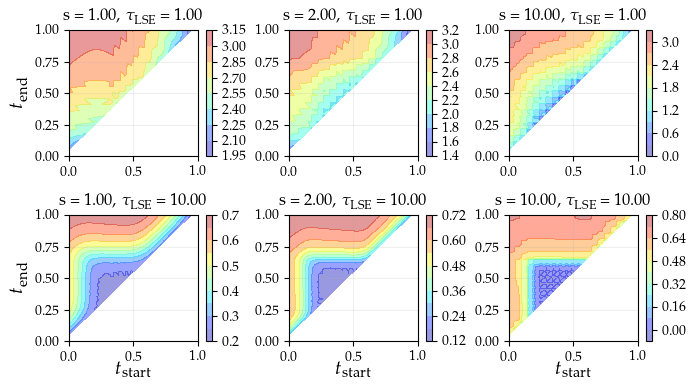

In [502]:
approx_method = "logsumexp"
plt.figure(figsize=(7,4))
scales = [1., 2., 10.]
temps = [1., 10.]
i = 1
for t in temps:
    for s in scales:
        plt.subplot(2,3,i)
        visualize_loss_landscape(loss_batch, signals, s, approx_method, t, coeff)
        if i in [1,2,3]:
            plt.xlabel("")
        if i in [2, 3,5, 6]:
            plt.ylabel("")
        i += 1
plt.tight_layout()

In [4]:
# analyzing gradients

pred = Predicate('x', lambda x: x)
rec = EventuallyRecurrent(pred > 0.)
ev = Eventually(pred > 0.)


In [5]:
T = 10
signal = jnp.arange(T) * 1.
# signal = jnp.array(np.random.randn(T))
signal_flip = jnp.flip(signal)


In [21]:
approx_method = "logsumexp"
temperature = 1.
axis = 0
keepdims = True



def test_grad(signal, temperature, approx_method):
    signal_flip = jnp.flip(signal)
    m = lambda x: maxish(x, axis=axis, keepdims=keepdims, approx_method=approx_method, temperature=temperature)
    # s0 = jnp.array([signal[0]])
    s0 = jnp.zeros(0)
    for s in signal_flip:
        s0 = m(jnp.concat([s0, jnp.array([s])]))
    return s0.squeeze() 


mask_grads = jax.grad(ev.robustness)(signal, approx_method=approx_method, temperature=temperature)
rec_grads = jax.grad(test_grad)(signal, temperature, approx_method)
rec_grads = jax.grad(rec.robustness)(signal_flip, approx_method=approx_method, temperature=temperature)


In [38]:
def rec_robustness(signal, approx_method, temperature, padding=1E9):
    signal_flip = jnp.flip(signal)
    return rec(signal_flip, approx_method=approx_method, temperature=temperature, padding=padding)[-1]

In [40]:
def plot_gradients(temperature, approx_method):
    mask_grads = jax.grad(ev.robustness)(signal, approx_method=approx_method, temperature=temperature)
    # rec_grads = jnp.flip(jax.grad(rob, 1)(rec, signal_flip, approx_method=approx_method, temperature=temperature))
    # rec_grads = jax.grad(test_grad)(signal, temperature, approx_method)
    rec_grads = jax.grad(rec_robustness)(signal, approx_method=approx_method, temperature=temperature, padding=1E9)
    plt.bar(jnp.arange(T)-0.125, mask_grads, label="Mask", width=0.22, alpha=0.5)
    plt.bar(jnp.arange(T)+0.124, rec_grads, label="Rec.", width=0.22, alpha=0.5)
    height = max(mask_grads.max(), rec_grads.max())
    plt.vlines(jnp.argmax(signal), 0, height, zorder=-5, linestyle='--', label='True max')
    # plt.ylim([-0.2, 1.2])
    plt.grid()
    plt.title("$\\tau$ = %.2f"%temp)
    if i in [2, 3]:
        plt.xlabel("Timestep",labelpad=-2)
    if i in [0,2]:
        plt.ylabel("Gradient",labelpad=-2)

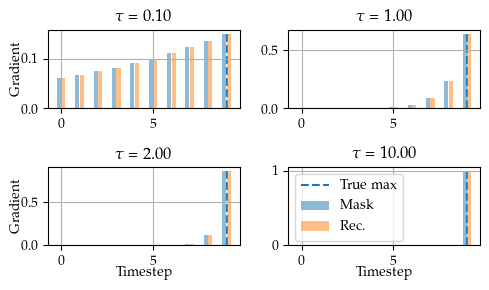

In [42]:
plt.figure(figsize=(5,3))
for (i, temp) in enumerate([0.1, 1., 2., 10.]):
    plt.subplot(2,2,i+1)
    plot_gradients(temp, approx_method)

plt.legend(loc="upper left")
plt.tight_layout()
# plt.savefig("figs/softmax_gradients.png", dpi=200, transparent=True)

In [43]:
temp_slider = widgets.FloatSlider(value=1., min=0.1, max=10., step=0.1, description='temperature:')
approx_method_slider = widgets.Dropdown(
    options=['true', "logsumexp", "softmax"],
    value='true',
    description='approx method:',
    disabled=False,
)
interact(plot_gradients, temperature=temp_slider, approx_method=approx_method_slider)


/Users/karen/venvs/test/lib/python3.12/site-packages/ipywidgets/widgets/interaction.py:43: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


interactive(children=(FloatSlider(value=1.0, description='temperature:', max=10.0, min=0.1), Dropdown(descript…

<function __main__.plot_gradients(temperature, approx_method)>

In [145]:
approx_method = "logsumexp"
temperature = 1.
scale = 1.
a = -2.1
b = 2.1
lr = 1E-1
max_steps = 5000
scale_start = 1.
scale_end = 20
temperature_start = 1.
temperature_end = 20
a_list = [a]
b_list = [b]

for i in range(max_steps):
    j = (i / max_steps)
    s = (1 - j) * scale_start + j * scale_end
    t = (1 - j) * temperature_start + j * temperature_end
    g = grad_loss_batch(signals, jax.nn.sigmoid(a), jax.nn.sigmoid(b), s, approx_method, t, coeff=0.5)
    a -= lr * g[0]
    b -= lr * g[1]
    a_list.append(a)
    b_list.append(b)
    print(a,b)


-2.1538367 2.148652
-2.2072356 2.1972725
-2.2602541 2.245861
-2.3129416 2.2944176
-2.3653393 2.342943
-2.417483 2.3914373
-2.4694035 2.4399016
-2.521127 2.488337
-2.5726762 2.536745
-2.624071 2.5851274
-2.6753283 2.6334853
-2.7264633 2.6818209
-2.7774892 2.730136
-2.8284173 2.7784321
-2.8792577 2.8267117
-2.9300191 2.8749764
-2.9807098 2.923228
-3.0313363 2.9714682
-3.081905 3.0196989
-3.132421 3.0679214
-3.1828895 3.1161373
-3.2333145 3.164348
-3.2837002 3.2125545
-3.3340497 3.260758
-3.3843663 3.3089595
-3.4346523 3.35716
-3.4849105 3.4053605
-3.5351431 3.4535613
-3.585352 3.501763
-3.635539 3.5499666
-3.6857057 3.5981722
-3.7358534 3.6463802
-3.7859838 3.694591
-3.8360977 3.7428048
-3.8861964 3.7910218
-3.9362807 3.8392422
-3.9863517 3.8874662
-4.0364103 3.9356937
-4.086457 3.9839249
-4.1364923 4.03216
-4.1865172 4.080398
-4.236532 4.12864
-4.2865376 4.1768856
-4.336534 4.2251344
-4.386522 4.2733865
-4.4365015 4.321642
-4.4864736 4.3699
-4.536438 4.4181614
-4.5863953 4.4664254
-4.63

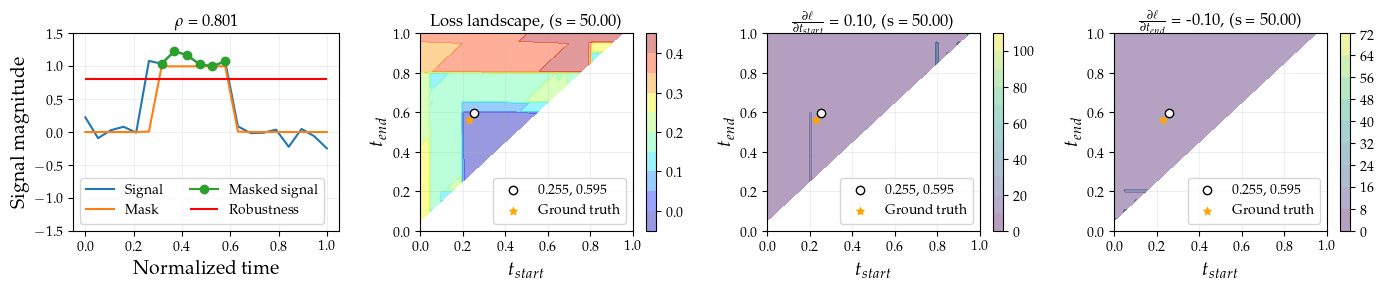

In [153]:
# brute force search
N = 201
scale = 50.
approx_method = "true"
temperature = 40.

starts, ends = jnp.meshgrid(jnp.linspace(0,1, N), jnp.linspace(0,1, N))
n = jnp.nanargmin(jax.vmap(loss_batch, [None, 0, 0, None, None, None])(signals, starts.reshape([-1]), ends.reshape([-1]), scale, approx_method, temperature))
t_start, t_end = starts.reshape([-1])[n], ends.reshape([-1])[n]
poo(signals[0], t_start, t_end, scale, approx_method, temperature)

In [314]:
N = 100
starts, ends = jnp.meshgrid(jnp.linspace(0,1, N), jnp.linspace(0,1, N))
jax.vmap(grad_loss, [None, 0, 0, None, None, None])(signals[0], starts.reshape([-1]), ends.reshape([-1]), scale, approx_method, temperature)


(Array([0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05], dtype=float32),
 Array([-0.05, -0.05, -0.05, ..., -0.05, -0.05, -0.05], dtype=float32))

In [155]:

    
    
approx_method = "logsumexp"
start_index_slider = widgets.FloatSlider(value=0.21, min=0.0, max=1., step=0.01, description='t_start: ')
end_index_slider = widgets.FloatSlider(value=0.59, min=0.0, max=1., step=0.01, description='t_end: ')
scale_index_slider = widgets.FloatSlider(value=1., min=1., max=50, step=1, description='scale: ')
temp_index_slider = widgets.FloatSlider(value=1., min=1., max=100, step=1, description='temperature: ')

interact(poo, signal=widgets.fixed(signals[0]), t_start=start_index_slider, t_end=end_index_slider, scale=scale_index_slider, approx_method=widgets.fixed(approx_method), temperature=temp_index_slider)

interactive(children=(FloatSlider(value=0.21, description='t_start: ', max=1.0, step=0.01), FloatSlider(value=…

<function __main__.poo(signal, t_start, t_end, scale, approx_method, temperature)>

In [31]:
bs =1024
T = 128
signal = jnp.array(np.random.random([bs, T]))
T = 8
while T <= 1024:
    signal = jnp.array(np.random.random([bs, T]))
    # %timeit jax.vmap(phi2, [0])(signal)
    foo = jax.grad(lambda signal: phi2(signal).mean())
    %timeit jax.vmap(foo)(signal)
    T *= 2


# T = 8
# while T <= 1024:
#     signal = jnp.array(np.random.random([bs, T]))
#     # %timeit jax.vmap(jax.jit(phi2), [0])(signal)
#     foo = jax.jit(jax.grad(lambda signal: phi2(signal).mean()))
#     %timeit jax.vmap(foo)(signal)

3.73 ms ± 53.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.49 ms ± 74.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.25 ms ± 393 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.7 ms ± 428 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
43.2 ms ± 124 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
143 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
753 ms ± 98.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.75 s ± 235 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
bs = 256
T = 128
signal = jnp.array(np.random.random([bs, T]))
T = 8
while T <= 1024:
    signal = jnp.array(np.random.random([bs, T]))
    # %timeit jax.vmap(phi2, [0])(signal)
    foo = jax.grad(lambda signal: phi2(signal).mean())
    %timeit jax.vmap(foo)(signal)
    T *= 2


T = 8
while T <= 1024:
    signal = jnp.array(np.random.random([bs, T]))
    # %timeit jax.vmap(jax.jit(phi2), [0])(signal)
    foo = jax.jit(jax.grad(lambda signal: phi2(signal).mean()))
    %timeit jax.vmap(foo)(signal)
    T *= 2

3.7 ms ± 265 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.64 ms ± 52.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.85 ms ± 224 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.49 ms ± 511 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
17.7 ms ± 781 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
45.1 ms ± 363 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
153 ms ± 758 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
753 ms ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
230 μs ± 1.14 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
308 μs ± 15.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.1 ms ± 14.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.76 ms ± 26.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.35 ms ± 156 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
19.7 ms ± 574 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
86.2 ms ± 1.03 ms pe

In [38]:
timeit.repeat("fo"+"o", globals=globals(), repeat=2, number=10)

[8.33999365568161e-07, 2.919696271419525e-07]

In [33]:
import timeit

In [16]:
T = 8
while T <= 1024:
    signal = jnp.array(np.random.random([bs, T]))
    # %timeit jax.vmap(phi, [0])(signal)
    foo = jax.grad(lambda signal: phi(signal).mean())
    %timeit jax.vmap(foo)(signal)
    T *= 2
    
T = 8
while T <= 1024:
    signal = jnp.array(np.random.random([bs, T]))
    # %timeit jax.vmap(jax.jit(phi), [0])(signal)
    foo = jax.jit(jax.grad(lambda signal: phi(signal).mean()))
    %timeit jax.vmap(foo)(signal)
    T *= 2

16 ms ± 831 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
29.1 ms ± 691 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
56.5 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
115 ms ± 553 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
228 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
447 ms ± 4.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
936 ms ± 4.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.94 s ± 72.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
159 μs ± 1.73 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
308 μs ± 130 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
505 μs ± 86.3 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
833 μs ± 151 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.8 ms ± 127 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.44 ms ± 236 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
17.2 ms ± 699 μs per loop (mean ± std. dev. o

In [15]:
Ts = [8, 16, 32, 64 ,128, 256, 528, 1024]
mask_mean = np.array([1.3, 1.33, 1.97, 3.87, 7.52, 20.2, 77.3, 464])
mask_std = np.array([52.2 / 1000, 39.1 / 1000, 6.6 / 1000, 175 / 1000, 227 / 1000, 434 / 1000, 1.76, 97.7])

mask_jit_mean = np.array([171 / 1000, 194 / 1000, 590 / 1000, 1.79 , 3.84 , 9.36 , 35 , 161])
mask_jit_std = np.array([3.24 / 1000, 2.33 / 1000, 4.35 / 1000, 41.6 / 1000, 112  / 1000, 511  / 1000, 782  / 1000, 3.47])

grad_mask_mean = np.array([3.83, 3.81, 5.09, 9.04, 18.8, 48.1, 155, 807])
grad_mask_std = np.array([83.6 / 1000, 144  / 1000, 141  / 1000, 318  / 1000, 849  / 1000, 1.86, 3.88, 205])

grad_mask_jit_mean = np.array([237 /1000, 300 / 1000, 1.12, 3.12, 7.73, 19.9, 85.4, 341])
grad_mask_jit_std = np.array([4.75 / 1000, 16.4 / 1000, 35.7 / 1000, 179 / 1000, 224 / 1000, 356 / 1000, 981 / 1000, 37.7])

In [ ]:
1.73 / 1000, 130  / 1000, 86.3 / 1000, 151  / 1000, 127  / 1000, 236  / 1000, 699  / 1000, 5.73

In [17]:
recurrent_mean = np.array([6.05, 11.5, 21.7, 42.9, 86, 171, 336, 669])
recurrent_std = np.array([68.2 / 1000, 464 / 1000, 337 / 1000, 734 / 1000, 2.46, 4.8, 7.11, 6.43])

recurrent_jit_mean = np.array([184 / 1000, 199 / 1000, 237 / 1000, 451 / 1000, 600 / 1000, 963 / 1000, 1.75 , 3.2])
recurrent_jit_std = np.array([7.38 / 1000, 4.72 / 1000, 3.67 / 1000, 134 / 1000, 95.4 / 1000, 125 / 1000, 177 / 1000, 367 / 1000])

grad_recurrent_mean = np.array([16, 29.1, 56.5, 115, 228, 447, 936, 1.94 * 1000])
grad_recurrent_std = np.array([831 /1000, 691 /1000, 1.23 /1000, 553 /1000, 10.9, 4.43, 4.94, 72.4])

grad_recurrent_jit_mean = np.array([159  / 1000, 308  / 1000, 505  / 1000, 833  / 1000, 1.8 , 5.44 , 17.2 , 58.5])
grad_recurrent_jit_std = np.array([1.73 / 1000, 130  / 1000, 86.3 / 1000, 151  / 1000, 127  / 1000, 236  / 1000, 699  / 1000, 5.73])

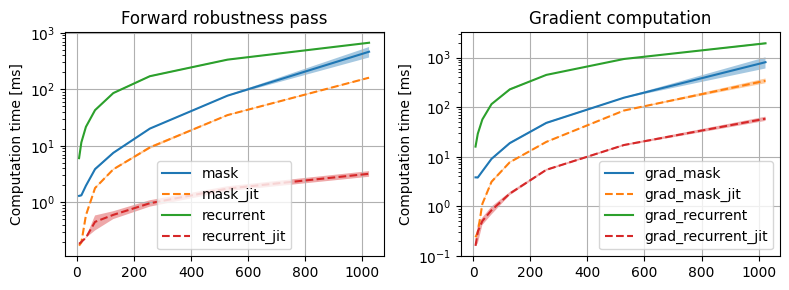

In [28]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(Ts, mask_mean, label="mask")
plt.fill_between(Ts, mask_mean + mask_std, mask_mean - mask_std, alpha=0.4)

plt.plot(Ts, mask_jit_mean, label="mask_jit", linestyle='--')
plt.fill_between(Ts, mask_jit_mean + mask_jit_std, mask_jit_mean - mask_jit_std, alpha=0.4)


plt.plot(Ts, recurrent_mean, label="recurrent")
plt.fill_between(Ts, recurrent_mean + recurrent_std, recurrent_mean - recurrent_std, alpha=0.4)

plt.plot(Ts, recurrent_jit_mean, label="recurrent_jit", linestyle='--')
plt.fill_between(Ts, recurrent_jit_mean + recurrent_jit_std, recurrent_jit_mean - recurrent_jit_std, alpha=0.4)

plt.yscale('log')
plt.ylabel('Computation time [ms]')
plt.grid()
plt.legend()
plt.title("Forward robustness pass")


plt.subplot(1,2,2)
plt.plot(Ts, grad_mask_mean, label="grad_mask")
plt.fill_between(Ts, grad_mask_mean + grad_mask_std, grad_mask_mean - grad_mask_std, alpha=0.4)

plt.plot(Ts, grad_mask_jit_mean, label="grad_mask_jit", linestyle='--')
plt.fill_between(Ts, grad_mask_jit_mean + grad_mask_jit_std, grad_mask_jit_mean - grad_mask_jit_std, alpha=0.4)


plt.plot(Ts, grad_recurrent_mean, label="grad_recurrent")
plt.fill_between(Ts, grad_recurrent_mean + grad_recurrent_std, grad_recurrent_mean - grad_recurrent_std, alpha=0.4)

plt.plot(Ts, grad_recurrent_jit_mean, label="grad_recurrent_jit", linestyle='--')
plt.fill_between(Ts, grad_recurrent_jit_mean + grad_recurrent_jit_std, grad_recurrent_jit_mean - grad_recurrent_jit_std, alpha=0.4)

plt.yscale('log')
plt.ylabel('Computation time [ms]')
plt.grid()
plt.legend()
plt.title("Gradient computation")

plt.tight_layout()


In [ ]:
phi = Until(pred > 4, pred < 4, interval=interval)
phi2 = Until2(pred_rev > 4, pred_rev < 4, interval=interval)

In [ ]:
import timeit

In [ ]:
timeit.

In [ ]:
%timeit jax.vmap(jax.jit(phi2), [0])(signal)
%timeit jax.vmap(jax.jit(phi), [0])(signal)

28.6 ms ± 612 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
119 ms ± 7.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit jax.vmap(phi2, [0])(signal)
%timeit jax.vmap(phi, [0])(signal)

83.9 ms ± 539 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


/Users/karen/repos/stljax/stljax/formula.py:388: UserWarning: Input Predicate "x" is not time reversed. Reversing the signal now...
  warnings.warn("Input Predicate \"{input_name}\" is not time reversed. Reversing the signal now...".format(input_name=self.lhs.name))
/Users/karen/repos/stljax/stljax/formula.py:329: UserWarning: Input Predicate "x" is not time reversed. Reversing the signal now...
  warnings.warn("Input Predicate \"{input_name}\" is not time reversed. Reversing the signal now...".format(input_name=self.lhs.name))


545 ms ± 8.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
foo = jax.jit(lambda signal: phi(signal, time_dim=time_dim, large_number=large_number, padding="last"))
foo(signal[0]);

In [ ]:
%timeit jax.vmap(foo, [0])(signal)

5.39 ms ± 46.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
phi.subformula(signal)

Array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.],      dtype=float32, weak_type=True)

In [ ]:
psi(signal, time_dim=time_dim, large_number=large_number, padding="last")

Array([-3., -2., -1.,  0.,  1.,  2.,  2.,  2.,  2.,  2.], dtype=float32)

In [ ]:
phi.subformula1(signal), phi.subformula2(signal)

(Array([ 6.,  5.,  4.,  3.,  2.,  1.,  0., -1., -2., -3.],      dtype=float32, weak_type=True),
 Array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],      dtype=float32, weak_type=True))

In [ ]:
T = 10
time_dim = 0
large_number = 100
interval = [2,4]
padding = "last"

signal1 = jnp.flip(jnp.arange(T))
signal2 = jnp.arange(T)

In [ ]:
class Until2(STL_Formula):
    def __init__(self, subformula1, subformula2, interval):
        super().__init__()
        self.subformula1 = subformula1
        self.subformula2 = subformula2
        self.interval = interval
    
    
    def robustness_trace(self, signal, time_dim=0, padding="last", large_number=1E9, **kwargs):
        if isinstance(signal, tuple):
            signal1, signal2 = signal
            signal1 = self.subformula1(signal1, time_dim=time_dim, padding=padding, large_number=large_number, **kwargs)
            signal2 = self.subformula2(signal2, time_dim=time_dim, padding=padding, large_number=large_number, **kwargs)
        else:
            signal1 = self.subformula1(signal, time_dim=time_dim, padding=padding, large_number=large_number, **kwargs)
            signal2 = self.subformula2(signal, time_dim=time_dim, padding=padding, large_number=large_number, **kwargs)
        
        T = signal.shape[time_dim]
        mask_value = large_number
        if self.interval is None:
            interval = [0,T]
        else:
            interval = self.interval
        signal1_matrix = signal1.reshape([T,1]) @ jnp.ones([1,T])
        signal2_matrix = signal2.reshape([T,1]) @ jnp.ones([1,T])
        if padding == "last":
            signal1_pad = jnp.ones([interval[1]+1, T]) * signal1[-1]
            signal2_pad = jnp.ones([interval[1]+1, T]) * signal2[-1]
        elif padding == "mean":
            signal1_pad = jnp.ones([interval[1]+1, T]) * signal1.mean(time_dim)
            signal2_pad = jnp.ones([interval[1]+1, T]) * signal2.mean(time_dim)
        else:
            signal1_pad = jnp.ones([interval[1]+1, T]) * padding
            signal2_pad = jnp.ones([interval[1]+1, T]) * padding

        signal1_padded = jnp.concatenate([signal1_matrix, signal1_pad], axis=time_dim)
        signal2_padded = jnp.concatenate([signal2_matrix, signal2_pad], axis=time_dim)
        
        start_idx = interval[0]
        phi1_mask = jnp.stack([jnp.triu(jnp.ones([T + interval[1]+1,T]), -end_idx) * jnp.tril(jnp.ones([T + interval[1]+1,T]), -start_idx) for end_idx in range(interval[0], interval[-1]+1)], 0)
        phi2_mask = jnp.stack([jnp.triu(jnp.ones([T + interval[1]+1,T]), -end_idx) * jnp.tril(jnp.ones([T + interval[1]+1,T]), -end_idx) for end_idx in range(interval[0], interval[-1]+1)], 0)
        phi1_masked_signal = jnp.stack([jnp.where(m1, signal1_padded, mask_value) for m1 in phi1_mask], 0)
        phi2_masked_signal = jnp.stack([jnp.where(m2, signal2_padded, mask_value) for m2 in phi2_mask], 0)
        return maxish(jnp.stack([minish(jnp.stack([minish(s1, axis=0, keepdims=False), minish(s2, axis=0, keepdims=False)], axis=0), axis=0, keepdims=False) for (s1, s2) in zip(phi1_masked_signal, phi2_masked_signal)], axis=0), axis=0, keepdims=False)

In [ ]:
maxish(signal, axis, approx_method="logsumexp", temperature=70.)

Array([9.], dtype=float32)

In [ ]:
signal.max(axis)

Array(9, dtype=int32)

In [ ]:
def get_position_states(trajectory):
    return trajectory[...,:2]

def compute_distance_to_position(trajectory, position):
    return jnp.linalg.norm(get_position_states(trajectory) - position, axis=-1, keepdims=True)

In [ ]:
trajectory = jnp.array(np.random.randn(4,10,1))
position = jnp.ones(2)
time_dim = 1


In [ ]:
exp = Expression("exp", value=2*trajectory, reverse=True, time_dim=time_dim)

pred = Predicate("pred", lambda x: 2 * x,
              reverse=True,
              time_dim=1)


In [ ]:
phi_exp = (exp>-3) & (exp<6)
phi_pred = (pred>-3) & (pred<6)

In [ ]:
phi_exp.eval_trace((exp, exp), time_dim=1, approx_method="softmax", temperature=3).squeeze()

Array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True, False, False,  True,  True,  True,  True,
         True]], dtype=bool)

In [ ]:
def poo(traj):
    return phi_pred.robustness(traj, time_dim=1, approx_method="softmax", temperature=100).squeeze().mean()

In [ ]:
signal = jnp.array(np.random.randn(4,10,3))
position = jnp.ones(2)

# don't need to worry about flipping

p = Predicate("distance to point",
              lambda x: compute_distance_to_position(x, position),
              reverse=False,
              time_dim=1)
dist = Expression("distance to point",
              compute_distance_to_position(signal, position),
              reverse=False)


phi = p < 2
psi = dist < 2

In [ ]:
Always(phi)(signal).shapea


/Users/karen/repos/stljax/stljax/formula.py:329: UserWarning: Input Predicate "distance to point" is not time reversed. Reversing the signal now...
  warnings.warn("Input Predicate \"{input_name}\" is not time reversed. Reversing the signal now...".format(input_name=self.lhs.name))


AttributeError: 'jaxlib.xla_extension.ArrayImpl' object has no attribute 'shapea'

In [ ]:
p2 = p - p

In [ ]:
class Predicate:
    name: str
    predicate_function: Callable
    reverse: bool

    def __init__(self, name, predicate_function=lambda x: x, reverse=False):
        self.name = name
        self.predicate_function = predicate_function
        self.reverse = reverse

    def set_name(self, new_name):
        self.name = new_name

    def __neg__(self):
        return Predicate('- ' + self.name, lambda x: -self.predicate_function(x), self.reverse)

    def __add__(self, other):
        if isinstance(other, Predicate):
            if self.reverse == other.reverse:
                return Predicate(self.name + ' + ' + other.name, lambda x: self.predicate_function(x) + other.predicate_function(x), self.reverse)
            else:
                raise ValueError("reverse attribute do not match")
        else:
            raise ValueError("Type error. Must be Predicate")

    def __radd__(self, other):
        return self.__add__(other)

    def __sub__(self, other):
        if isinstance(other, Predicate):
            if self.reverse == other.reverse:
                return Predicate(self.name + ' - ' + other.name, lambda x: self.predicate_function(x) - other.predicate_function(x), self.reverse)
            else:
                raise ValueError("reverse attribute do not match")
        else:
            raise ValueError("Type error. Must be Predicate")

    def __rsub__(self, other):
        return self.__sub__(other)
        # No need for the case when "other" is an Expression, since that
        # case will be handled by the regular sub

    def __mul__(self, other):
        if isinstance(other, Predicate):
            if self.reverse == other.reverse:
                return Predicate(self.name + ' x ' + other.name, lambda x: self.predicate_function(x) * other.predicate_function(x), self.reverse)
            else:
                raise ValueError("reverse attribute do not match")
        else:
            raise ValueError("Type error. Must be Predicate")



    def __rmul__(self, other):
        return self.__mul__(other)

    def __truediv__(a, b):        
        if isinstance(a, Predicate) and isinstance(b, Predicate):
            if a.reverse == b.reverse:
                return Predicate(a.name + ' / ' + b.name, lambda x: a.predicate_function(x) / b.predicate_function(x), a.reverse)
            else:
                raise ValueError("reverse attribute do not match")
        else:
            raise ValueError("Type error. Must be Predicate")



    # Comparators
    def __lt__(lhs, rhs):
        assert isinstance(lhs, str) | isinstance(lhs, Predicate), "LHS of LessThan needs to be a string or Predicate"
        assert not isinstance(rhs, str), "RHS cannot be a string"
        return LessThan(lhs, rhs)

    def __le__(lhs, rhs):
        assert isinstance(lhs, str) | isinstance(lhs, Predicate), "LHS of LessThan needs to be a string or Predicate"
        assert not isinstance(rhs, str), "RHS cannot be a string"
        return LessThan(lhs, rhs)

    def __gt__(lhs, rhs):
        assert isinstance(lhs, str) | isinstance(lhs, Predicate), "LHS of GreaterThan needs to be a string or Predicate"
        assert not isinstance(rhs, str), "RHS cannot be a string"
        return GreaterThan(lhs, rhs)

    def __ge__(lhs, rhs):
        assert isinstance(lhs, str) | isinstance(lhs, Predicate), "LHS of GreaterThan needs to be a string or Predicate"
        assert not isinstance(rhs, str), "RHS cannot be a string"
        return GreaterThan(lhs, rhs)

    def __eq__(lhs, rhs):
        assert isinstance(lhs, str) | isinstance(lhs, Predicate), "LHS of Equal needs to be a string or Predicate"
        assert not isinstance(rhs, str), "RHS cannot be a string"
        return Equal(lhs, rhs)


    def __call__(self, input, **kwargs):
        return self.predicate_function(input, **kwargs)


In [ ]:
p = Predicate("distance to point", lambda x: compute_distance_to_position(x, position))
q = Expression("distance to point", compute_distance_to_position(signal, position), True)

In [ ]:
p < 2

In [ ]:
p(signal)

In [ ]:
class LessThan(STL_Formula):
    """
    The LessThan predicate  (signal) < c
    lhs < val where lhs is a placeholder for a signal, and val is the constant.
    lhs can be a string or an Expression
    val can be a float, int, Expression, or tensor. It cannot be a string.
    """
    def __init__(self, lhs='x', val='c'):
        super().__init__()
        assert isinstance(lhs, str) | isinstance(lhs, Expression) | isinstance(lhs, Predicate), "LHS of expression needs to be a string (input name) or Expression"
        assert not isinstance(val, str), "val on the rhs cannot be a string"
        self.lhs = lhs
        self.val = val
        self.subformula = None

    def robustness_trace(self, trace, predicate_scale=1.0, **kwargs):
        """
        Computing robustness trace of trace < c
        Optional: scale the robustness by a factor predicate_scale. Default: 1.0
        """
        c = self.val
        if isinstance(trace, Expression):
            trace = trace.value
        if isinstance(self.val, Expression):
            c = self.val.value
        if isinstance(self.lhs, Predicate):
            trace = self.lhs(trace)
        return (c - trace) * predicate_scale

    def _next_function(self):
        """ next function is the input subformula. For visualization purposes """
        return [self.lhs, self.val]

    def __str__(self):
        lhs_str = self.lhs
        if isinstance(self.lhs, Expression) | isinstance(self.lhs, Predicate):
            lhs_str = self.lhs.name
        if isinstance(self.val, str): # could be a string if robustness_trace is never called
            return lhs_str + " < " + self.val
        if isinstance(self.val, Expression):
            return lhs_str + " < " + self.val.name
        if isinstance(self.val, jax.Array):
            return lhs_str + " < " + str(self.val)
        # if self.value is a single number (e.g., int, or float)
        return lhs_str + " < " + str(self.val)

In [ ]:
class Expression2(Predicate):
    name: str
    value: jnp.array
    reverse: bool

    def __init__(self, name, value, reverse):
        self.value = value
        self.name = name
        self.reverse = reverse

    def set_name(self, new_name):
        self.name = new_name

    def set_value(self, new_value):
        self.value = new_value

    def flip(self, dim):
        self.value = jnp.flip(self.value, dim)
        self.reverse = not self.reverse
        return self.value


In [ ]:
phi = LessThan(p, 0.5)

In [ ]:
p(signal).flip(1)

Array([[[1.874767  ],
        [3.3078563 ],
        [2.2001715 ],
        [1.0200646 ],
        [1.4154869 ],
        [1.130065  ],
        [1.7873935 ],
        [1.8831584 ],
        [1.31098   ],
        [0.54721415]],

       [[1.2246962 ],
        [2.5346096 ],
        [1.5016233 ],
        [2.4999607 ],
        [1.6508234 ],
        [1.8224314 ],
        [2.4444437 ],
        [1.2667884 ],
        [0.9918787 ],
        [3.2671225 ]],

       [[2.2443008 ],
        [0.3089164 ],
        [2.0610437 ],
        [2.0803547 ],
        [1.5925725 ],
        [2.1341612 ],
        [0.61172307],
        [0.33576143],
        [2.1304526 ],
        [0.8546321 ]],

       [[0.86676663],
        [1.7898709 ],
        [2.874513  ],
        [1.4333472 ],
        [1.6880858 ],
        [1.7915444 ],
        [2.0730488 ],
        [0.63144565],
        [2.504658  ],
        [2.2948897 ]]], dtype=float32)

In [ ]:
phi(p(signal).flip(1))

In [ ]:
print(phi)

distance to point < 0.5


In [ ]:
phi2 = q < 0.5

In [ ]:
layer = eqx.nn.Linear(2, 8, key=key1)

In [ ]:
layer.weight.shape

(8, 2)

In [ ]:
layer(signal[0,0].T)

Array([ 0.9083887 ,  1.3642473 , -0.55188483, -0.7947735 , -0.7574743 ,
       -0.43824098,  0.94598097,  0.03964314], dtype=float32)

In [ ]:
@eqx.filter_jit
@eqx.filter_grad
def loss_fn(model, x, y):
    pred_y = jax.vmap(model)(x)
    return jax.numpy.mean((y - pred_y)**2)

# batch_size, in_size, out_size = 1, 1, 1
# model = Predicate(in_size, out_size, key=jax.random.PRNGKey(0))
# x = jax.numpy.ones((batch_size, in_size)) * 2
# y = jax.numpy.zeros((batch_size, out_size))
grads = loss_fn(model, x, y)

In [ ]:
signal = jax.random.normal(x_key, (4, 10, 2))

In [ ]:
x_key, y_key, model_key = jax.random.split(jax.random.PRNGKey(0), 3)
x, y = jax.random.normal(x_key, (100, 2)), jax.random.normal(y_key, (100, 2))
# model = Predicate(model_key)
key1, key2 = jax.random.split(model_key)
layer = eqx.nn.Linear(2, 8, key=key1)

In [ ]:
T = 10
time_dim = 1
signal_ = jnp.array(np.concatenate([np.arange(T), - np.arange(T)]).reshape(1,-1,1))
signal_exp = Expression("signal", signal_, True)



In [ ]:
Implies(signal_exp < 0, signal_exp<0)((signal_,signal_)).shape

(1, 20, 1)

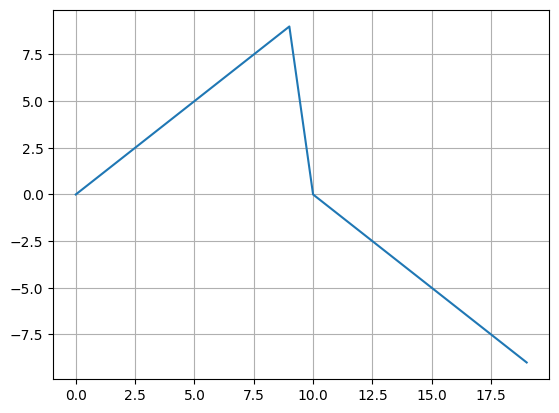

In [ ]:
plt.plot(signal_[0,:,0])
plt.grid()

In [ ]:
ϕ = signal_exp < 0
ψ = signal_exp > 0
interval = None
overlap=False
formula = Until(ϕ, ψ, interval=interval, overlap=overlap)
signal = (signal_, signal_)
kwargs = {}


In [ ]:
trace1 = ϕ(signal_)
trace2 = ψ(signal_)

# LHS = trace2.unsqueeze(-1).repeat([1, 1, 1,trace2.shape[1]]).permute(0, 3, 2, 1)

In [ ]:
signal_

Array([[[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [ 0],
        [-1],
        [-2],
        [-3],
        [-4],
        [-5],
        [-6],
        [-7],
        [-8],
        [-9]]], dtype=int32)

In [ ]:
interval

In [ ]:
jnp.stack([formula(signal, time_dim=1)[0,:,0], jnp.arange(2*T)], axis=-1)

Array([[ 0.,  0.],
       [-1.,  1.],
       [-2.,  2.],
       [-3.,  3.],
       [-4.,  4.],
       [-5.,  5.],
       [-6.,  6.],
       [-7.,  7.],
       [-8.,  8.],
       [-9.,  9.],
       [ 0., 10.],
       [ 0., 11.],
       [ 0., 12.],
       [ 0., 13.],
       [ 0., 14.],
       [ 0., 15.],
       [ 0., 16.],
       [ 0., 17.],
       [ 0., 18.],
       [ 0., 19.]], dtype=float32)

In [ ]:
jnp.stack([trace1[0,:,0], trace2[0,:,0], jnp.arange(2*T)], axis=-1)

Array([[ 0.,  0.,  0.],
       [-1.,  1.,  1.],
       [-2.,  2.,  2.],
       [-3.,  3.,  3.],
       [-4.,  4.,  4.],
       [-5.,  5.,  5.],
       [-6.,  6.,  6.],
       [-7.,  7.,  7.],
       [-8.,  8.,  8.],
       [-9.,  9.,  9.],
       [ 0.,  0., 10.],
       [ 1., -1., 11.],
       [ 2., -2., 12.],
       [ 3., -3., 13.],
       [ 4., -4., 14.],
       [ 5., -5., 15.],
       [ 6., -6., 16.],
       [ 7., -7., 17.],
       [ 8., -8., 18.],
       [ 9., -9., 19.]], dtype=float32, weak_type=True)

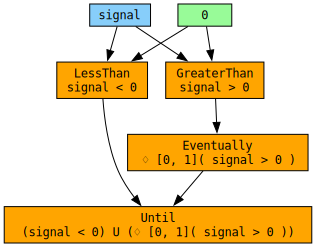

In [ ]:
make_stl_graph(formula)

In [ ]:
formula((signal, signal), time_dim=1)

/Users/karen/venvs/test/lib/python3.12/site-packages/debugpy/_vendored/pydevd/pydev_ipython/matplotlibtools.py:55: MatplotlibDeprecationWarning: The interactive_bk attribute was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use ``matplotlib.backends.backend_registry.list_builtin(matplotlib.backends.BackendFilter.INTERACTIVE)`` instead.
  from matplotlib.rcsetup import interactive_bk, non_interactive_bk  # @UnresolvedImport
/Users/karen/venvs/test/lib/python3.12/site-packages/debugpy/_vendored/pydevd/pydev_ipython/matplotlibtools.py:55: MatplotlibDeprecationWarning: The non_interactive_bk attribute was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use ``matplotlib.backends.backend_registry.list_builtin(matplotlib.backends.BackendFilter.NON_INTERACTIVE)`` instead.
  from matplotlib.rcsetup import interactive_bk, non_interactive_bk  # @UnresolvedImport


Array([[[-0.14847128],
        [-0.15039094],
        [-0.47802144],
        [-0.90179425],
        [-0.02390359],
        [-0.10767389],
        [-0.37743065],
        [-0.77710134],
        [-0.09523206],
        [-0.6273695 ],
        [-0.11685494],
        [-0.11685494],
        [-0.11685494],
        [-0.11685494],
        [-0.11685494],
        [-0.11685494],
        [-0.11685494],
        [-0.11685494],
        [-0.11685494],
        [-0.11685494]]], dtype=float32)

In [ ]:
Alw = Always(subformula=Identity(name=str(ϕ)))
LARGE_NUMBER = 10
LHS = jnp.permute_dims(jnp.repeat(jnp.expand_dims(trace2, -1), T, axis=-1), [0,3,2,1])  # [bs, sub_signal, state, t_prime]
# LHS = jnp.moveaxis(jnp.repeat(jnp.expand_dims(trace2, -1), T, axis=-1), (time_dim, -1), (-1, time_dim))  # [bs, sub_signal, state, t_prime]

RHS = jnp.ones_like(LHS) * -LARGE_NUMBER  # [bs, sub_signal, state, t_prime]
kwargs = {}

In [ ]:
for i in range(T):
    RHS = RHS.at[:,i:,:,i].set(Alw(trace1[:,i:,:]))
maxish(minish(jnp.stack([LHS, RHS], axis=-1), axis=-1, keepdims=False, **kwargs), axis=-1, keepdims=False, **kwargs).shape

(2, 10, 1)

In [ ]:
RHS = jnp.ones_like(LHS) * -LARGE_NUMBER  # [bs, sub_signal, state, t_prime]
a = 3
b = 3
interval = [a,b]
for i in range(T):
    end = i+b+1
    RHS = RHS.at[:,i+a:end,:,i].set(Alw(trace1[:,i:end,:])[:,a:,:])
maxish(minish(jnp.stack([LHS, RHS], axis=-1), axis=-1, keepdims=False, **kwargs), axis=-1, **kwargs)[0,:,0,0]

Array([-10.       , -10.       , -10.       ,  -1.8272067,  -1.8272067,
        -2.3922586,  -1.4882705,  -3.1234703,  -2.1971922,  -3.3019428],      dtype=float32)

In [ ]:
RHS = jnp.ones_like(LHS) * -LARGE_NUMBER  # [bs, sub_signal, state, t_prime]
a = 1
# interval = [a,∞] 
for i in range(T):
    RHS = RHS.at[:,i+a:,:,i].set(Alw(trace1[:,i:,:])[:,a:,:])
maxish(minish(jnp.stack([LHS, RHS], axis=-1), axis=-1, keepdims=False, **kwargs), axis=-1, **kwargs)[0,:,0,0]

Array([-10.       ,  -2.5137436,  -2.5137436,  -1.8250105,  -1.8250105],      dtype=float32)

In [ ]:
RHS[0,:,0,]

Array([-10.        , -10.        ,  -0.17498949,  -0.17498949,
        -0.17498949], dtype=float32)

In [ ]:
trace2[0,:,0]

Array([-2.5137436, -2.8437529, -1.8250105, -2.065979 , -3.5846837],      dtype=float32)

In [ ]:
i = 0
a = 1
b = 2
interval = [a,b]
LHS = jnp.permute_dims(jnp.repeat(jnp.expand_dims(trace2, -1), b-a+1, axis=-1), [0,3,2,1])  # [bs, sub_signal, state, t_prime]
for i in range(T):
    temp = Alw(trace1[:,i:,:])

In [ ]:
LHS.shape

(1, 2, 1, 6)

In [ ]:
trace1[0,:,0]

Array([-0.37370402, -0.73211664,  0.7075581 ,  1.0568783 , -1.3028616 ,
       -0.10485458], dtype=float32)

In [ ]:
Alw = Always(subformula=Identity(name=str(self.subformula1)))
        minish = Minish()
        maxish = Maxish()
        LHS = trace2.unsqueeze(-1).repeat([1, 1, 1,trace2.shape[1]]).permute(0, 3, 2, 1)
        if interval == None:
            RHS = torch.ones_like(LHS)*-LARGE_NUMBER
            for i in range(trace2.shape[1]):
                RHS[:,i:,:,i] = Alw(trace1[:,i:,:])
            return maxish(
                            minish(torch.stack([LHS, RHS], dim=-1), scale=scale, dim=-1, keepdim=False, agm=agm, distributed=distributed),
                        scale=scale, dim=-1, keepdim=False, agm=agm, distributed=distributed)

IndentationError: unexpected indent (3330790792.py, line 2)

In [ ]:
@jax.jit 
def bar_plus(signal, p=2):
    return jax.nn.relu(signal)**p

@jax.jit 
def bar_minus(signal, p=2):
    return (-jax.nn.relu(-signal))**p

def M0(signal, eps, weights=None, axis=1):
    if weights is None:
        weights = jnp.ones_like(signal)
    sum_w = weights.sum(axis)
    return (eps**sum_w + jnp.prod(signal ** weights, axis=axis)) ** (1 / sum_w)

def Mp(signal, eps, p, weights=None, axis=1):
    if weights is None:
        weights = jnp.ones_like(signal)
    sum_w = weights.sum(axis)
    return (eps ** p + 1 / sum_w * jnp.sum(weights * signal**p, axis=axis)) ** (1 / p)

def gmsr_min_(signal, eps, p, weights=None, axis=1):
    return M0(bar_plus(signal, 2), eps, weights=weights, axis=axis) ** 0.5 - Mp(bar_minus(signal, 2), eps, p, weights=weights, axis=axis) ** 0.5

def gmsr_max_(signal, eps, p, weights=None, axis=1):
    return -gmsr_min_(-signal, eps, p, weights=weights, axis=axis)


#### test ####
eps = 0.1
p = 2

# time_dim = 1 [bs, time_dim, state_dim]
axis = 1
signal = jnp.array(np.random.randn(4,10,2))
gmsr_min_(signal, eps, p, axis=axis), gmsr_max_(signal, eps, p, axis=axis)

# time_dim = 0 (1D array)
axis = 0
signal = jnp.array(np.random.randn(10))
gmsr_min_(signal, eps, p, axis=axis), gmsr_max_(signal, eps, p, axis=axis)

(Array(-1.0609021, dtype=float32), Array(0.8129965, dtype=float32))

In [ ]:
@jax.jit
def bar_plus(signal, p=2):
    return jax.nn.relu(signal) ** p

@jax.jit
def bar_minus(signal, p=2):
    return (-jax.nn.relu(-signal)) ** p


def M0(signal, eps, weights=None, axis=1, keepdims=True):
    if weights is None:
        weights = jnp.ones_like(signal)
    sum_w = weights.sum(axis, keepdims=keepdims)
    return (
        eps**sum_w + jnp.prod(signal**weights, axis=axis, keepdims=keepdims)
    ) ** (1 / sum_w)


def Mp(signal, eps, p, weights=None, axis=1, keepdims=True):
    if weights is None:
        weights = jnp.ones_like(signal)
    sum_w = weights.sum(axis, keepdims=keepdims)
    return (
        eps**p + 1 / sum_w * jnp.sum(weights * signal**p, axis=axis, keepdims=keepdims)
    ) ** (1 / p)


def gmsr_min(signal, eps, p, weights=None, axis=1, keepdims=True):
    return (
        M0(bar_plus(signal, 2), eps, weights=weights, axis=axis, keepdims=keepdims)
        ** 0.5
        - Mp(
            bar_minus(signal, 2), eps, p, weights=weights, axis=axis, keepdims=keepdims
        )
        ** 0.5
    )


def gmsr_max(signal, eps, p, weights=None, axis=1, keepdims=True):
    return -gmsr_min(-signal, eps, p, weights=weights, axis=axis, keepdims=keepdims)


def gmsr_min_turbo(signal, eps, p, weights=None, axis=1, keepdims=True):
    pos_idx = signal > 0.0
    neg_idx = ~pos_idx

    if signal[neg_idx].size > 0:
        h_min = (
            eps**0.5
            - Mp(
                bar_minus(signal, 2),
                eps,
                p,
                weights=weights,
                axis=axis,
                keepdims=keepdims,
            )
            ** 0.5
        )
    else:
        h_min = (
            M0(bar_plus(signal, 2), eps, weights=weights, axis=axis, keepdims=keepdims)
            ** 0.5
            - eps**0.5
        )
    return h_min


def gmsr_max_turbo(signal, eps, p, weights=None, axis=1, keepdims=True):
    return -gmsr_min_turbo(
        -signal, eps, p, weights=weights, axis=axis, keepdims=keepdims
    )


def gmsr_min_fast(signal, eps, p):
    # TODO: (norrisg) allow `axis` specification

    # Split indices into positive and non-positive values
    pos_idx = signal > 0.0
    neg_idx = ~pos_idx

    weights = jnp.ones_like(signal)

    # Sum of all weights
    sum_w = weights.sum()

    # If there exists a negative element
    if signal[neg_idx].size > 0:
        sums = 0.0
        sums = jnp.sum(weights[neg_idx] * (signal[neg_idx] ** (2 * p)))
        Mp = (eps**p + (sums / sum_w)) ** (1 / p)
        h_min = eps**0.5 - Mp**0.5

    # If all values are positive
    else:
        mult = 1.0
        mult = jnp.prod(signal[pos_idx] ** (2 * weights[pos_idx]))
        M0 = (eps**sum_w + mult) ** (1 / sum_w)
        h_min = M0**0.5 - eps**0.5

    return jnp.reshape(h_min, (1, 1, 1))


def gmsr_max_fast(signal, eps, p):
    return -gmsr_min_fast(-signal, eps, p)


def gmsr_min_turbo_karen(signal, eps, p, weights=None, axis=1, keepdims=True):
    pos_idx = signal > 0.0
    neg_idx = ~pos_idx
    return jnp.where(neg_idx.sum(axis, keepdims=keepdims) > 0,
                        eps**0.5
                        - Mp(
                            bar_minus(signal, 2),
                            eps,
                            p,
                            weights=weights,
                            axis=axis,
                            keepdims=keepdims,
                        ) ** 0.5,
                        M0(bar_plus(signal, 2), eps, weights=weights, axis=axis, keepdims=keepdims)
                        ** 0.5
                        - eps**0.5
                        )

def gmsr_max_turbo_karen(signal, eps, p, weights=None, axis=1, keepdims=True):
    return -gmsr_min_turbo(
        -signal, eps, p, weights=weights, axis=axis, keepdims=keepdims
    )

In [ ]:
signal_1D = jnp.array(np.random.randn(100))
signal_2D = jnp.array(np.concatenate( [np.random.randn(100,4), np.random.randn(100,4)**2, -np.random.randn(100,4)**2], axis=0))

axis = 0
eps = 0.1
p = 2

In [ ]:
# check if 1D matches
gmsr_min_turbo(signal_1D, eps, p, axis=axis), gmsr_min_turbo_karen(signal_1D, eps, p, axis=axis)

(Array([-0.90919816], dtype=float32), Array([-0.90919816], dtype=float32))

In [ ]:
signal_2D = jnp.array(np.concatenate( [np.random.randn(2,4), np.random.randn(2,4)**2, -np.random.randn(2,4)**2], axis=0))
axis = 1
keepdims = False
gmsr_min_turbo(signal_2D, eps, p, axis=axis, keepdims=keepdims), gmsr_min_turbo_karen(signal_2D, eps, p, axis=axis, keepdims=keepdims), [gmsr_min_turbo(s, eps, p, axis=0, keepdims=keepdims) for s in signal_2D]

(Array([ 0.        , -0.08901224,  0.        ,  0.        , -7.8393583 ,
        -0.1615533 ], dtype=float32),
 Array([ 2.6449791e-01, -8.9012235e-02,  7.6677203e-03,  6.3477433e-01,
        -7.8393583e+00, -1.6155329e-01], dtype=float32),
 [Array(0.2644979, dtype=float32),
  Array(-0.08901224, dtype=float32),
  Array(0.00766772, dtype=float32),
  Array(0.6347743, dtype=float32),
  Array(-7.8393583, dtype=float32),
  Array(-0.1615533, dtype=float32)])

In [ ]:
%timeit jax.vmap(gmsr_min_turbo_karen, [0, None, None, None, None, None])(signal_2D, eps, p, None, 0, keepdims)

14.4 ms ± 418 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
signal_2D = jnp.array(np.concatenate( [np.random.randn(4,50), np.random.randn(4,50)**2, -np.random.randn(4,50)**2], axis=0))
axis = 1
keepdims = False
eps = 1E-8
p = 1

In [ ]:
%timeit gmsr_min_turbo_karen(signal_2D, eps, p, axis=axis, keepdims=keepdims)
%timeit gmsr_min(signal_2D, eps, p, axis=axis, keepdims=keepdims)

845 μs ± 18.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
798 μs ± 7.03 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%timeit gmsr_min(signal_2D, eps, p, axis=axis, keepdims=keepdims)

794 μs ± 21.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


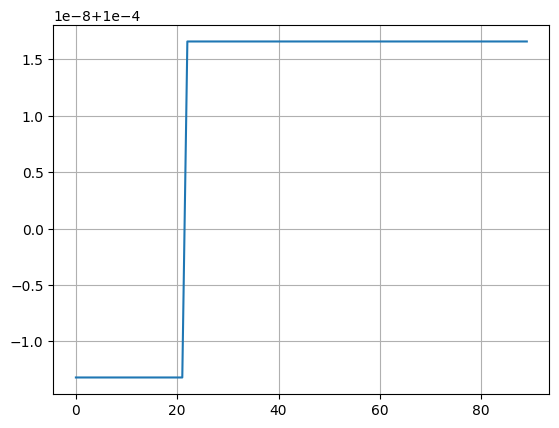

In [ ]:
axis=0
keepdim=0
error = []
N = 100
eps = 1E-8
p = 1
signal_1D = jnp.array(np.random.randn(N))
for n in range(10, 100):
    s = signal_1D[:n]
    error.append(jnp.abs(gmsr_min_turbo_karen(s, eps, p, axis=axis, keepdims=keepdims) - gmsr_min(s, eps, p, axis=axis, keepdims=keepdims)))

plt.plot(error)
plt.grid()


In [ ]:
error

[Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(9.998679e-05, dtype=float32),
 Array(0.00010002, dtype=float32),
 Array(0.00010002, dtype=float32),
 Array(0.00010002, dtype=float32),
 Array(0.00010002, dtype=float32),
 Array(0.00010002, dtype=float32),
 Array(0.00

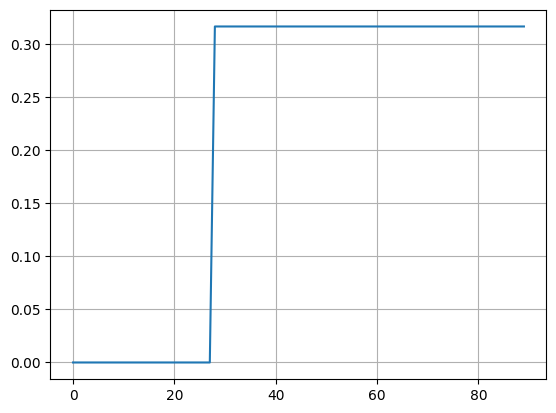

In [ ]:
import matplotlib.pyplot as plt
plt.plot(error)
plt.grid()


In [ ]:
signal = jnp.array(np.random.randn(100))
%timeit gmsr_min_(signal, eps, p, axis=axis), gmsr_max_(signal, eps, p, axis=axis)

# samet's code
%timeit gmsr_min(signal, eps, p), gmsr_max(signal, eps, p)

1.59 ms ± 21.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.93 ms ± 227 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit bar_plus(signal, p=2)

305 μs ± 10.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%timeit jax.jit(bar_plus)(signal, p=2)

138 μs ± 430 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
# time_dim = 1
axis = 1
signal = jnp.array(np.random.randn(4,10,2))
gmsr_min(signal, eps, p, axis=axis), gmsr_max(signal, eps, p, axis=axis)

# time_dim = 0 (1D array)
axis = 0
signal = jnp.array(np.random.randn(10))
gmsr_min(signal, eps, p, axis=axis), gmsr_max(signal, eps, p, axis=axis)

(Array([[-0.35404286, -0.5021552 ],
        [-0.99138343, -1.0022707 ],
        [-0.10483399, -0.19867209],
        [-0.13136926, -0.8537588 ]], dtype=float32),
 Array([[0.23893866, 1.0163467 ],
        [0.20035574, 0.01356971],
        [0.37372681, 0.74906814],
        [0.52578354, 0.23363969]], dtype=float32))

In [ ]:
# time_dim = 0 (1D array)
axis = 0
signal = jnp.array(np.random.randn(10))
gmsr_min_(signal, eps, p, axis=axis), gmsr_max_(signal, eps, p, axis=axis)

(Array(-0.6915504, dtype=float32), Array(0.66988015, dtype=float32))

In [ ]:
gmsr_min(signal[0,:,0], eps, p), gmsr_max(signal[0,:,0], eps, p)

(Array([[[-0.03458041]]], dtype=float32),
 Array([[[0.30581143]]], dtype=float32))

In [ ]:
Mp(signal**2, eps, p, time_dim=time_dim)

Array(1.9231288, dtype=float32)

In [ ]:
signal = jnp.array(np.random.randn(10))
time_dim = 0

M0(bar_plus(signal, 2), eps, time_dim=time_dim) ** 0.5 - Mp(bar_minus(signal, 2), eps, p, time_dim=time_dim) ** 0.5

Array(-0.75458395, dtype=float32)

In [ ]:
gmsr_min(signal, eps, p)

Array([[[-0.75458395]]], dtype=float32)

In [ ]:
weights = jnp.ones_like(signal)
time_dim = 1
eps = 0.1
p = 2

In [ ]:
sum_w = weights.sum(time_dim)

In [ ]:
(eps ** p + 1 / sum_w * jnp.sum(weights * signal**p, axis=time_dim)) ** (1 / p)

Array([[1.227763 , 1.1784164],
       [1.081313 , 0.9632835],
       [1.2601703, 1.2951891],
       [1.3407898, 0.7029362]], dtype=float32)

In [ ]:
(eps**weights.sum(time_dim) + jnp.prod(signal ** weights, axis=time_dim))

Array([[-1.8319769e-01, -7.5817863e-03],
       [-2.4664927e-02, -7.1364449e-04],
       [ 2.4716083e-02,  2.1452385e-01],
       [-4.6522971e-04,  1.2528546e-04]], dtype=float32)

In [ ]:
(eps**weights.sum(time_dim) + jnp.prod(signal ** weights, axis=time_dim)) ** (1 / weights.sum(time_dim))

Array([[      nan,       nan],
       [      nan,       nan],
       [0.6907135, 0.8573291],
       [      nan, 0.4071834]], dtype=float32)

In [ ]:
bar_minus(signal, 2)

Array([[[0.0000000e+00, 1.5153936e-01],
        [2.0087442e+00, 6.8098783e+00],
        [0.0000000e+00, 0.0000000e+00],
        [1.8454798e+00, 0.0000000e+00],
        [0.0000000e+00, 9.4424207e-03],
        [0.0000000e+00, 2.1630211e+00],
        [0.0000000e+00, 5.0628227e-01],
        [0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00],
        [7.2148025e-01, 0.0000000e+00]],

       [[2.6926812e-02, 1.5949025e+00],
        [0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 4.6746522e-02],
        [0.0000000e+00, 0.0000000e+00],
        [5.4876714e+00, 2.7320065e+00],
        [1.0274620e-01, 2.9917788e-03],
        [0.0000000e+00, 1.8421818e-03]],

       [[0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.8584354e+00],
        [1.6228565e+00, 3.7360773e+00],
        [0.0000000e+00, 2.0105479e+00],
        [3.1005695e+00, 1.5079595e+0

In [ ]:
pos_idx = signal > 0.0
neg_idx = ~pos_idx

weights = jnp.ones_like(signal)

# Sum of all weights
sum_w = weights.sum()

# # If there exists a negative element
# if signal[neg_idx].size > 0:
#     sums = 0.0
#     sums = jnp.sum(weights[neg_idx] * (signal[neg_idx] ** (2 * p)))
#     Mp = (eps**p + (sums / sum_w)) ** (1 / p)
#     h_min = eps**0.5 - Mp**0.5

# # If all values are positive
# else:
#     mult = 1.0
#     mult = jnp.prod(signal[pos_idx] ** (2 * weights[pos_idx]))
#     M0 = (eps**sum_w + mult) ** (1 / sum_w)
#     h_min = M0**0.5 - eps**0.5


In [ ]:
pos_idx

Array([[[ True, False],
        [False, False],
        [ True,  True],
        [False,  True],
        [ True, False],
        [ True, False],
        [ True, False],
        [ True,  True],
        [ True,  True],
        [False,  True]],

       [[False, False],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True, False],
        [ True,  True],
        [False, False],
        [False, False],
        [ True, False]],

       [[ True,  True],
        [ True, False],
        [False, False],
        [ True, False],
        [False, False],
        [False,  True],
        [False,  True],
        [False,  True],
        [False, False],
        [ True, False]],

       [[False,  True],
        [ True, False],
        [False,  True],
        [ True,  True],
        [False,  True],
        [ True,  True],
        [ True,  True],
        [False, False],
        [False,  True],
        [ True,  True]]], dtype=bool)

In [ ]:
gmsr_min(signal**2, 0.2, 3)

Array([[[-0.4472136]]], dtype=float32)

In [ ]:
jnp.prod?

Signature:
jnp.prod(
    a: 'ArrayLike',
    axis: 'Axis' = None,
    dtype: 'DTypeLike | None' = None,
    out: 'None' = None,
    keepdims: 'bool' = False,
    initial: 'ArrayLike | None' = None,
    where: 'ArrayLike | None' = None,
    promote_integers: 'bool' = True,
) -> 'Array'
Docstring:
Return the product of array elements over a given axis.

LAX-backend implementation of :func:`numpy.prod`.

*Original docstring below.*

Parameters
----------
a : array_like
    Input data.
axis : None or int or tuple of ints, optional
    Axis or axes along which a product is performed.  The default,
    axis=None, will calculate the product of all the elements in the
    input array. If axis is negative it counts from the last to the
    first axis.
dtype : dtype, optional
    The type of the returned array, as well as of the accumulator in
    which the elements are multiplied.  The dtype of `a` is used by
    default unless `a` has an integer dtype of less precision than the
    default pla

In [ ]:
class Expression:
    name: str
    value: jnp.array
    reverse: bool

    def __init__(self, name, value, reverse):
        self.value = value
        self.name = name
        self.reverse = reverse

    def set_name(self, new_name):
        self.name = new_name

    def set_value(self, new_value):
        self.value = new_value

    def flip(self, dim):
        self.value = jnp.flip(self.value, dim)
        self.reverse = not self.reverse
        return self.value
    
    def __neg__(self):
        return Expression('-' + self.name, -self.value, self.reverse)
    
    def __add__(self, other):
        if isinstance(other, Expression):
            if self.reverse == other.reverse:
                return Expression(self.name + ' + ' + other.name, self.value + other.value, self.reverse)
            else:
                raise ValueError("reverse attribute do not match")
        else:
            return Expression(self.name + ' + other', self.value + other, self.reverse)

    def __radd__(self, other):
        return self.__add__(other)
    
    def __sub__(self, other):
        if isinstance(other, Expression):
            if self.reverse == other.reverse:
                return Expression(self.name + ' - ' + other.name, self.value - other.value, self.reverse)
            else:
                raise ValueError("reverse attribute do not match")        
        else:
            return Expression(self.name + " - other", self.value - other, self.reverse)

    def __rsub__(self, other):
        return self.__sub__(other)
        # No need for the case when "other" is an Expression, since that
        # case will be handled by the regular sub

    def __mul__(self, other):
        if isinstance(other, Expression):
            if self.reverse == other.reverse:
                return Expression(self.name + ' × ' + other.name, self.value * other.value, self.reverse)
            else:
                raise ValueError("reverse attribute do not match")    
        else:
            return Expression(self.name + " * other", self.value * other, self.reverse)


    def __rmul__(self, other):
        return self.__mul__(other)

    def __truediv__(a, b):
        # This is the new form required by Python 3
        numerator = a
        denominator = b
        if numerator.reverse == denominator.reverse:
            return Expression(numerator.name + '/' + denominator.name, numerator.value/denominator.value, denominator.reverse)
        else:
            raise ValueError("reverse attribute do not match") 
        

    # Comparators
    def __lt__(lhs, rhs):
        assert isinstance(lhs, str) | isinstance(lhs, Expression), "LHS of LessThan needs to be a string or Expression"
        assert not isinstance(rhs, str), "RHS cannot be a string"
        return LessThan(lhs, rhs)

    def __le__(lhs, rhs):
        assert isinstance(lhs, str) | isinstance(lhs, Expression), "LHS of LessThan needs to be a string or Expression"
        assert not isinstance(rhs, str), "RHS cannot be a string"
        return LessThan(lhs, rhs)

    def __gt__(lhs, rhs):
        assert isinstance(lhs, str) | isinstance(lhs, Expression), "LHS of GreaterThan needs to be a string or Expression"
        assert not isinstance(rhs, str), "RHS cannot be a string"
        return GreaterThan(lhs, rhs)

    def __ge__(lhs, rhs):
        assert isinstance(lhs, str) | isinstance(lhs, Expression), "LHS of GreaterThan needs to be a string or Expression"
        assert not isinstance(rhs, str), "RHS cannot be a string"
        return GreaterThan(lhs, rhs)

    def __eq__(lhs, rhs):
        assert isinstance(lhs, str) | isinstance(lhs, Expression), "LHS of Equal needs to be a string or Expression"
        assert not isinstance(rhs, str), "RHS cannot be a string"
        return Equal(lhs, rhs)

    # def __ne__(lhs, rhs):
    #     raise NotImplementedError("Not supported yet")

    # def __str__(self):
    #     return str(self.name)
    
    def __call__(self):
        return self.value


In [ ]:
x = jnp.array(np.random.randn(4,10,2))

velocity = Expression("vel", x, False)
doggy = Expression("dog", x, False)

In [ ]:
def maxish(signal, axis, keepdims=True, approx_method="true", temperature=None):
    if isinstance(signal, Expression):
        assert signal.value is not None, "Input Expression does not have numerical values"
        signal = signal.value

    if approx_method == "true":
        '''jax keeps track of multiple max values and will distribute the gradients across all max values!
        e.g., jax.grad(jnp.max)(jnp.array([0.01, 0.0, 0.01])) # --> Array([0.5, 0. , 0.5], dtype=float32)
        '''
        return jnp.max(signal, axis, keepdims=keepdims)
    
    if approx_method == "logsumexp":
        '''https://jax.readthedocs.io/en/latest/_autosummary/jax.scipy.special.logsumexp.html'''
        assert temperature is not None, "need a temperature value"
        return jax.scipy.special.logsumexp(temperature * signal, axis=axis, keepdims=keepdims) / temperature
    
    if approx_method == "softmax":
        assert temperature is not None, "need a temperature value"
        return (jax.nn.softmax(temperature * signal, axis) * signal).sum(axis, keepdims=keepdims)
    

def minish(signal, axis, keepdims=True, approx_method="true", temperature=None):
    return -maxish(-signal, axis, keepdims, approx_method, temperature)

    

In [ ]:
def convert_to_input_values(inputs):
    x_, y_ = inputs
    if isinstance(x_, Expression):
        assert x_.value is not None, "Input Expression does not have numerical values"
        x_ret = x_.value
    elif isinstance(x_, jax.Array):
        x_ret = x_
    elif isinstance(x_, tuple):
        x_ret = convert_to_input_values(x_)
    else:
        raise ValueError("First argument is an invalid input trace")

    if isinstance(y_, Expression):
        assert y_.value is not None, "Input Expression does not have numerical values"
        y_ret = y_.value
    elif isinstance(y_, jax.Array):
        y_ret = y_
    elif isinstance(y_, tuple):
        y_ret = convert_to_input_values(y_)
    else:
        raise ValueError("Second argument is an invalid input trace")

    return (x_ret, y_ret)

def tensor_to_str(tensor):
    '''
    turn tensor into a string for printing
    '''
    device = tensor.device.type
    req_grad = tensor.requires_grad
    if req_grad == False:
        return "input"
    tensor = tensor.detach()
    if device == "cuda":
        tensor = tensor.cpu()
    return str(tensor.numpy())


In [ ]:
import warnings
warnings.simplefilter("default")

In [ ]:
class STL_Formula:

    def __init__(self):
        super(STL_Formula, self).__init__()

    def robustness_trace(self, signal, **kwargs):
                        #  time_dim=1,
                        #  keepdims=False,
                        #  approx_method=None,
                        #  temperature=None,
                        #  predicate_scale=None):
        """ Computes the robustness trace of the formula given an input signal. 
        Outputs: tensor [bs, time_dim,...]
        """
        raise NotImplementedError("robustness_trace not yet implemented")

    def robustness(self, signal, time_dim, **kwargs):
                #    time_dim=1, 
                #    keepdims=False,
                #    approx_method=None, 
                #    temperature=None, 
                #    predicate_scale=None):
        """
        Extracts the robustness_trace value at the given time.
        Assumes signal is time reversed

        """
        # np.rollaxis(a, axis)[state]
        return jnp.rollaxis(self.__call__(signal, **kwargs), time_dim)[-1]

    def eval_trace(self, signal, **kwargs):
                #    time_dim=1, 
                #    keepdims=False,
                #    approx_method=None, 
                #    temperature=None, 
                #    predicate_scale=None):
        """ The values in eval_trace are 0 or 1 (False or True) """
        return self.__call__(signal, **kwargs) > 0

    def eval(self, signal, time_dim, **kwargs):
            #  time_dim=1, 
            #  keepdims=False,
            #  approx_method=None, 
            #  temperature=None, 
            #  predicate_scale=None):
        """
        Extracts the eval_trace value at the given time.
        Default: time=0 assuming this is the index for the NON-REVERSED trace. But the code will take it from the end since the input signal is TIME REVERSED.
        """
        return self.robustness(signal, time_dim, **kwargs) > 0


    def __call__(self, signal, **kwargs):
                    # time_dim=1,
                    # keepdims=False,
                    # approx_method=None,
                    # temperature=None,
                    # predicate_scale=None):
        """
        Extracts the robustness_trace value at the given time.
        Default: time=0 assuming this is the index for the NON-REVERSED trace. But the code will take it from the end since the input signal is TIME REVERSED.

        """
        
        """
        Evaluates the robustness_trace given the input. The input is converted to the numerical value first.
        """
        if isinstance(signal, Expression):
            assert signal.value is not None, "Input Expression does not have numerical values"
            if not signal.reverse:
                warnings.warn("Input Expression \"{input_name}\" is not time reversed".format(input_name=signal.name))
            signal = signal.value
            return self.robustness_trace(signal, **kwargs)
        elif isinstance(signal, jax.Array):
            return self.robustness_trace(signal, **kwargs)
        elif isinstance(signal, tuple):
            """ Accounts for the case that the formula requires two signal (e.g., And) """
            return self.robustness_trace(convert_to_input_values(signal), **kwargs)
        else:
            raise ValueError("Not a invalid input trace")
        
    def _next_function(self):
        """Function to keep track of the subformulas. For visualization purposes"""
        raise NotImplementedError("_next_function not year implemented")
    
    def __str__(self):
        raise NotImplementedError("__str__ not yet implemented")

    """ Overwriting some built-in functions for notational simplicity """
    def __and__(self, psi):
        return And(self, psi)

    def __or__(self, psi):
        return Or(self, psi)

    def __invert__(self):
        return Negation(self)


In [ ]:
class LessThan(STL_Formula):
    """
    The LessThan predicate  (signal) < c 
    lhs < val where lhs is a placeholder for a signal, and val is the constant.
    lhs can be a string or an Expression
    val can be a float, int, Expression, or tensor. It cannot be a string.
    """
    def __init__(self, lhs='x', val='c'):
        super().__init__()
        assert isinstance(lhs, str) | isinstance(lhs, Expression), "LHS of expression needs to be a string (input name) or Expression"
        assert not isinstance(val, str), "val on the rhs cannot be a string"
        self.lhs = lhs
        self.val = val
        self.subformula = None

    def robustness_trace(self, trace, predicate_scale=1.0, **kwargs):
        """
        Computing robustness trace of trace < c 
        Optional: scale the robustness by a factor predicate_scale. Default: 1.0
        """
        if isinstance(trace, Expression):
            trace = trace.value
        if isinstance(self.val, Expression):
            return (self.val.value - trace) * predicate_scale
        else:
            return (self.val - trace) * predicate_scale

    def _next_function(self):
        """ next function is the input subformula. For visualization purposes """
        return [self.lhs, self.val]

    def __str__(self):
        lhs_str = self.lhs
        if isinstance(self.lhs, Expression):
            lhs_str = self.lhs.name
        if isinstance(self.val, str): # could be a string if robustness_trace is never called
            return lhs_str + " < " + self.val
        if isinstance(self.val, Expression):
            return lhs_str + " < " + self.val.name
        if isinstance(self.val, jax.Array):
            return lhs_str + " < " + str(jax.Array)
        # if self.value is a single number (e.g., int, or float)
        return lhs_str + " < " + str(self.val)
    
class GreaterThan(STL_Formula):
    """
    The GreaterThan predicate  (signal) > c 
    lhs > val where lhs is a placeholder for a signal, and val is the constant.
    lhs can be a string or an Expression
    val can be a float, int, Expression, or tensor. It cannot be a string.
    """
    def __init__(self, lhs='x', val='c'):
        super().__init__()
        assert isinstance(lhs, str) | isinstance(lhs, Expression), "LHS of expression needs to be a string (input name) or Expression"
        assert not isinstance(val, str), "val on the rhs cannot be a string"
        self.lhs = lhs
        self.val = val
        self.subformula = None

    def robustness_trace(self, trace, predicate_scale=1.0, **kwargs):
        """
        Computing robustness trace of trace > c 
        Optional: scale the robustness by a factor predicate_scale. Default: 1.0
        """
        if isinstance(trace, Expression):
            trace = trace.value
        if isinstance(self.val, Expression):
            return -(self.val.value - trace) * predicate_scale
        else:
            return -(self.val - trace) * predicate_scale

    def _next_function(self):
        """ next function is the input subformula. For visualization purposes """
        return [self.lhs, self.val]

    def __str__(self):
        lhs_str = self.lhs
        if isinstance(self.lhs, Expression):
            lhs_str = self.lhs.name
        if isinstance(self.val, str): # could be a string if robustness_trace is never called
            return lhs_str + " > " + self.val
        if isinstance(self.val, Expression):
            return lhs_str + " > " + self.val.name
        if isinstance(self.val, jax.Array):
            return lhs_str + " > " + str(jax.Array)
        # if self.value is a single number (e.g., int, or float)
        return lhs_str + " > " + str(self.val)
    
    

class Equal(STL_Formula):
    """
    The Equal predicate  (signal) == c 
    lhs == val where lhs is a placeholder for a signal, and val is the constant.
    lhs can be a string or an Expression
    val can be a float, int, Expression, or tensor. It cannot be a string.
    """
    def __init__(self, lhs='x', val='c'):
        super().__init__()
        assert isinstance(lhs, str) | isinstance(lhs, Expression), "LHS of expression needs to be a string (input name) or Expression"
        assert not isinstance(val, str), "val on the rhs cannot be a string"
        self.lhs = lhs
        self.val = val
        self.subformula = None

    def robustness_trace(self, trace, predicate_scale=1.0, **kwargs):
        """
        Computing robustness trace of trace == c 
        Optional: scale the robustness by a factor predicate_scale. Default: 1.0
        """
        if isinstance(trace, Expression):
            trace = trace.value
        if isinstance(self.val, Expression):
            return -jnp.abs(self.val.value - trace) * predicate_scale
        else:
            return -jnp.abs(self.val - trace) * predicate_scale

    def _next_function(self):
        """ next function is the input subformula. For visualization purposes """
        return [self.lhs, self.val]

    def __str__(self):
        lhs_str = self.lhs
        if isinstance(self.lhs, Expression):
            lhs_str = self.lhs.name
        if isinstance(self.val, str): # could be a string if robustness_trace is never called
            return lhs_str + " == " + self.val
        if isinstance(self.val, Expression):
            return lhs_str + " == " + self.val.name
        if isinstance(self.val, jax.Array):
            return lhs_str + " == " + str(jax.Array)
        # if self.value is a single number (e.g., int, or float)
        return lhs_str + " == " + str(self.val)
    
    
class Negation(STL_Formula):
    """
    The Negation STL formula ¬
    Negates the subformula.

    Input
    subformula --- the subformula to be negated
    """
    def __init__(self, subformula):
        super(Negation, self).__init__()
        self.subformula = subformula

    def robustness_trace(self, trace, **kwargs):
        """
        Computing robustness trace of ¬(subformula)
        """
        return -self.subformula(trace, **kwargs)

    def _next_function(self):
        """ next function is the input subformula. For visualization purposes """
        return [self.subformula]

    def __str__(self):
        return "¬(" + str(self.subformula) + ")"




In [ ]:
class And(STL_Formula):
    """
    The And STL formula ∧ (subformula1 ∧ subformula2)
    Input
    subformula1 --- subformula for lhs of the And operation
    subformula2 --- subformula for rhs of the And operation
    """
    def __init__(self, subformula1, subformula2):
        super().__init__()
        self.subformula1 = subformula1
        self.subformula2 = subformula2

    @staticmethod
    def separate_and(formula, input_, **kwargs):
        """
        Function of seperate out multiple And operations. e.g., ϕ₁ ∧ ϕ₂ ∧ ϕ₃ ∧ ϕ₄ ∧ ...    
        """
        if formula.__class__.__name__ != "And":
            return jnp.expand_dims(formula(input_, **kwargs), -1)
        else:
            return jnp.concatenate([And.separate_and(formula.subformula1, input_[0], **kwargs), And.separate_and(formula.subformula2, input_[1], **kwargs)], axis=-1)

    def robustness_trace(self, inputs, **kwargs):
        """
        Computing robustness trace of subformula1 ∧ subformula2
        Input
        inputs --- a tuple of input traces corresponding to each subformula respectively. Each element of the tuple could also be a tuple if the corresponding subformula requires multiple inputs (e.g, ϕ₁(x) ∧ (ϕ₂(y) ∧ ϕ₃(z)) would have inputs=(x, (y,z)))
        trace1 and trace2 are size [batch_size, time_dim, x_dim]
        """
        xx = And.separate_and(self, inputs, **kwargs)
        return minish(xx, axis=-1, keepdims=False, **kwargs)                                         # [batch_size, time_dim, ...]

    def _next_function(self):
        """ next function is the input subformulas. For visualization purposes """
        return [self.subformula1, self.subformula2]

    def __str__(self):
        return "(" + str(self.subformula1) + ") ∧ (" + str(self.subformula2) + ")"
    

class Or(STL_Formula):
    """
    The Or STL formula ∨ (subformula1 ∨ subformula2)
    Input
    subformula1 --- subformula for lhs of the And operation
    subformula2 --- subformula for rhs of the And operation
    """
    def __init__(self, subformula1, subformula2):
        super().__init__()
        self.subformula1 = subformula1
        self.subformula2 = subformula2

    @staticmethod
    def separate_and(formula, input_, **kwargs):
        """
        Function of seperate out multiple And operations. e.g., ϕ₁ ∨ ϕ₂ ∨ ϕ₃ ∨ ϕ₄ ∨ ...    
        """
        if formula.__class__.__name__ != "Or":
            return jnp.expand_dims(formula(input_, **kwargs), -1)
        else:
            return jnp.concatenate([Or.separate_and(formula.subformula1, input_[0], **kwargs), Or.separate_and(formula.subformula2, input_[1], **kwargs)], axis=-1)

    def robustness_trace(self, inputs, **kwargs):
        """
        Computing robustness trace of subformula1 ∧ subformula2
        Input
        inputs --- a tuple of input traces corresponding to each subformula respectively. Each element of the tuple could also be a tuple if the corresponding subformula requires multiple inputs (e.g, ϕ₁(x) ∨ (ϕ₂(y) ∨ ϕ₃(z)) would have inputs=(x, (y,z)))
        trace1 and trace2 are size [batch_size, time_dim, x_dim]
        """
        xx = Or.separate_and(self, inputs, **kwargs)
        return maxish(xx, axis=-1, keepdims=False, **kwargs)                                         # [batch_size, time_dim, ...]

    def _next_function(self):
        """ next function is the input subformulas. For visualization purposes """
        return [self.subformula1, self.subformula2]

    def __str__(self):
        return "(" + str(self.subformula1) + ") ∨ (" + str(self.subformula2) + ")"



In [ ]:
from stljax.formula import STL_Formula

In [ ]:
phi = velocity < 4.

In [ ]:
to = Temporal_Operator(ϕ)

In [ ]:
to._initialize_hidden_state(velocity(), 1).shape

(4, 1, 2)

In [ ]:
class Temporal_Operator(STL_Formula):
    """
    Class to compute Eventually and Always. This builds a recurrent cell to perform dynamic programming
    
    Inputs
    subformula --- The subformula that the temporal operator is applied to.
    interval   --- The time interval that the temporal operator operates on. 
                   Default: None which means [0, jnp.inf]. Other options car be: [a, b] (b < jnp.inf), [a, jnp.inf] (a > 0)
    NOTE: Assume that the interval is describing the INDICES of the desired time interval. The user is responsible for converting the time interval (in time units) into indices (integers) using knowledge of the time step size.
    """
    def __init__(self, subformula, interval=None):
        super().__init__()
        self.subformula = subformula
        self.interval = interval
        self._interval = [0, jnp.inf] if self.interval is None else self.interval
        self.hidden_dim = 1 if not self.interval else self.interval[-1]    # hidden_dim=1 if interval is [0, ∞) otherwise hidden_dim=end of interval
        if self.hidden_dim == jnp.inf:
            self.hidden_dim = self.interval[0]
        self.steps = 1 if not self.interval else self.interval[-1] - self.interval[0] + 1   # steps=1 if interval is [0, ∞) otherwise steps=length of interval
        self.operation = None
        # Matrices that shift a vector and add a new entry at the end.
        self.M = jnp.diag(jnp.ones(self.hidden_dim-1), k=1)
        self.b = jnp.expand_dims(jnp.zeros(self.hidden_dim), -1)
        self.b = self.b.at[-1].set(1)


    def _initialize_hidden_state(self, signal):

        """
        Compute the initial hidden state.
        
        Input
        signal --- the input signal [batch_size, time_dim, signal_dim]

        Output
        h0 --- initial hidden state is [batch_size, hidden_dim, signal_dim]

        Notes:
        Initializing the hidden state requires padding on the signal. Currently, the default is to extend the last value.
        TODO: have option on this padding

        """
        # Case 1, 2, 4
        # TODO: make this less hard-coded. Assumes signal is [bs, time_dim, signal_dim], and already reversed
        h0 = jnp.ones([signal.shape[0], self.hidden_dim, signal.shape[2]])*signal[:,:1,:]

        # Case 3: if self.interval is [a, jnp.inf), then the hidden state is a tuple (like in an LSTM)
        if (self._interval[1] == jnp.inf) & (self._interval[0] > 0):
            c0 = signal[:,:1,:]
            return (c0, h0)
        return h0

    def _cell(self, x, hidden_state, time_dim=1, **kwargs):
        """
        This function describes the operation that takes place at each recurrent step.
        Input: 
        x  --- the input state at time t [batch_size, 1, ...]
        hidden_state --- the hidden state. It is either a tensor, or a tuple of tensors, depending on the interval chosen and other arguments. Generally, the hidden state is of size [batch_size, hidden_dim,...]
        """
        raise NotImplementedError("_cell is not implemented")


    def _run_cell(self, signal, time_dim=1, **kwargs):
        """
        Function to run a signal through a cell T times, where T is the length of the signal in the time dimension
        Input
        signal      --- input signal, size = [bs, time_dim, ...]
        scale       --- scale factor used for the minish/maxish function
        distributed --- Boolean to indicate whether to distribute gradients over multiple min/max values. Default: False

        """

        outputs = []
        states = []
        hidden_state = self._initialize_hidden_state(signal)                               # [batch_size, hidden_dim, x_dim]
        signal_split = jnp.split(signal, signal.shape[time_dim], time_dim)    # list of x at each time step
        for i in range(signal.shape[time_dim]):
            o, hidden_state = self._cell(signal_split[i], hidden_state, time_dim, **kwargs)
            outputs.append(o)
            states.append(hidden_state)
        return outputs, states


    def robustness_trace(self, inputs, time_dim=1, **kwargs):
        """
        Function to compute robustness trace of a temporal STL formula
        First, compute the robustness trace of the subformula, and use that as the input for the recurrent computation
        """
        
        trace = self.subformula(inputs, **kwargs)
        outputs, _ = self._run_cell(trace, time_dim, **kwargs)
        return jnp.concatenate(outputs, axis=time_dim)                              # [batch_size, time_dim, ...]

    def _next_function(self):
        """ next function is the input subformula. For visualization purposes """
        return [self.subformula]


In [ ]:
class Always(Temporal_Operator):
    """
    The Always STL formula □_[a,b] 
    The robustness value is the minimum value of the input trace over a prespecified time interval

    Input
    subformula --- subformula that the always operation is applied on
    interval   --- time interval [a,b] where a, b are indices along the time dimension. It is up to the user to keep track of what the timestep is.
    """
    def __init__(self, subformula, interval=None):
        super().__init__(subformula=subformula, interval=interval)

    def _cell(self, x, hidden_state, time_dim, **kwargs):
        """
        This function describes the operation that takes place at each recurrent step.
        Input: 
        x  --- the input state at time t [batch_size, 1, ...]
        hidden_state --- the hidden state is of size [batch_size, rnn_dim,...]
        """
        
        # Case 1, interval = [0, inf]
        if self.interval is None:
            input_ = jnp.concatenate([hidden_state, x], axis=time_dim)                # [batch_size, rnn_dim+1, x_dim]
            output = minish(input_, time_dim, keepdims=True, **kwargs)       # [batch_size, 1, x_dim]
            return output, output

        # Case 3: self.interval is [a, np.inf)
        if (self._interval[1] == np.inf) & (self._interval[0] > 0):
            c, h = hidden_state
            ch = jnp.concatenate([c, h[:,:1,:]], axis=time_dim)                             # [batch_size, 2, x_dim]
            output = minish(ch, time_dim, keepdims=True, **kwargs)               # [batch_size, 1, x_dim]
            hidden_state = (output, self.M @ h + self.b * x)
        # Case 2 and 4: self.interval is [a, b]
        else: 
            
            hidden_state = self.M @ hidden_state + self.b * x
            hx = jnp.concatenate([hidden_state, x], axis=time_dim)                             # [batch_size, rnn_dim+1, x_dim]
            input_ = hx[:,:self.steps,:]                               # [batch_size, self.steps, x_dim]
            output = minish(input_, time_dim, **kwargs)               # [batch_size, 1, x_dim]
        return output, hidden_state

    def __str__(self):
        return "◻ " + str(self._interval) + "( " + str(self.subformula) + " )"


In [ ]:
class Eventually(Temporal_Operator):
    """
    The Eventually STL formula □_[a,b] 
    The robustness value is the minimum value of the input trace over a prespecified time interval

    Input
    subformula --- subformula that the Eventually operation is applied on
    interval   --- time interval [a,b] where a, b are indices along the time dimension. It is up to the user to keep track of what the timestep is.
    """
    def __init__(self, subformula, interval=None):
        super().__init__(subformula=subformula, interval=interval)

    def _cell(self, x, hidden_state, time_dim, **kwargs):
        """
        This function describes the operation that takes place at each recurrent step.
        Input: 
        x  --- the input state at time t [batch_size, 1, ...]
        hidden_state --- the hidden state is of size [batch_size, rnn_dim,...]
        """
        
        # Case 1, interval = [0, inf]
        if self.interval is None:
            input_ = jnp.concatenate([hidden_state, x], axis=time_dim)                # [batch_size, rnn_dim+1, x_dim]
            output = maxish(input_, time_dim, keepdims=True, **kwargs)       # [batch_size, 1, x_dim]
            return output, output

        # Case 3: self.interval is [a, np.inf)
        if (self._interval[1] == np.inf) & (self._interval[0] > 0):
            c, h = hidden_state
            ch = jnp.concatenate([c, h[:,:1,:]], axis=time_dim)                             # [batch_size, 2, x_dim]
            output = maxish(ch, time_dim, keepdims=True, **kwargs)               # [batch_size, 1, x_dim]
            hidden_state = (output, self.M @ h + self.b * x)
        # Case 2 and 4: self.interval is [a, b]
        else: 
            
            hidden_state = self.M @ hidden_state + self.b * x
            hx = jnp.concatenate([hidden_state, x], axis=time_dim)                             # [batch_size, rnn_dim+1, x_dim]
            input_ = hx[:,:self.steps,:]                               # [batch_size, self.steps, x_dim]
            output = maxish(input_, time_dim, **kwargs)               # [batch_size, 1, x_dim]
        return output, hidden_state

    def __str__(self):
        return "♢ " + str(self._interval) + "( " + str(self.subformula) + " )"


In [ ]:
x = jnp.array(np.random.randn(10,60,4))

velocity = Expression("vel", x, False)
doggy = Expression("dog", x, False)

In [ ]:
phi = velocity > 0.
q = Eventually(phi, interval=[1,jnp.inf])

In [ ]:
q(velocity(), time_dim=1).shape

(10, 60, 4)

In [ ]:
loss = lambda x: q(x, time_dim=1).mean()
grad_func = jax.jit(jax.grad(loss))

In [ ]:
grad_func(velocity())

Array([[[0.00125   , 0.00166667, 0.00208333, 0.00125   ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.01375   , 0.        , 0.        , 0.01749999],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.00125   , 0.00083333, 0.00083333, 0.00125   ],
        [0.        , 0.00041667, 0.0025    , 0.        ],
        [0.00041667, 0.02374999, 0.        , 0.00083333],
        ...,
        [0.        , 0.        , 0.        , 0.00083333],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.00083333, 0.00166667, 0.00083333, 0.02499999],
        [0.00125   , 0.        , 0.00083333, 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.      

In [ ]:
%timeit grad_func(velocity())

154 µs ± 2.64 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
import matplotlib.pyplot as plt

Case 3


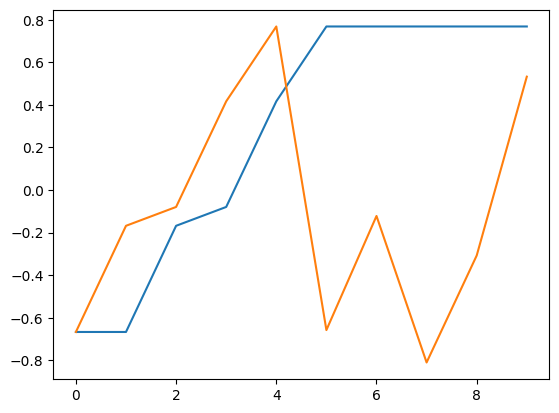

In [ ]:
plt.plot(q(velocity()[:1,:,:1], time_dim=1)[0])
plt.plot(phi(x[0,:,0]))

In [ ]:
phi(x[0,:])

Array([[4.667129 , 3.5631566],
       [4.16825  , 4.3827624],
       [4.079684 , 3.0395007],
       [3.5834174, 4.182486 ],
       [3.23165  , 3.9678671],
       [4.658202 , 2.4858408],
       [4.122091 , 4.2464976],
       [4.810453 , 4.088218 ],
       [4.307857 , 5.0584717],
       [3.4674907, 4.9147296]], dtype=float32)

In [ ]:
time_dim  = 1
velocity.flip(time_dim);


In [ ]:
velocity.reverse

True

In [ ]:
ϕ = velocity > 0.0
ψ = Negation(doggy > 1.0)

In [ ]:
~ϕ

In [ ]:
θ =  ϕ & ϕ | ψ

In [ ]:
inputs = ((velocity, -2*velocity), doggy)

In [ ]:
θ.robustness(inputs, time_dim, approx_method="logsumexp", temperature=100)

Array([[ 0.30556798,  3.81142   ],
       [ 0.74136907,  1.4686741 ],
       [ 1.4230956 ,  1.5800385 ],
       [ 1.0207751 , -0.31602427]], dtype=float32)

In [ ]:
θ.robustness(inputs, time_dim, approx_method="softmax", temperature=100)

Array([[ 0.30556798,  3.81142   ],
       [ 0.7413691 ,  1.468674  ],
       [ 1.4230956 ,  1.5800385 ],
       [ 1.0207751 , -0.3199868 ]], dtype=float32)

In [ ]:
θ.robustness(inputs, time_dim)

Array([[ 0.30556798,  3.81142   ],
       [ 0.7413691 ,  1.468674  ],
       [ 1.4230956 ,  1.5800385 ],
       [ 1.0207751 , -0.31747746]], dtype=float32)

In [ ]:
loss = lambda x, y: θ(((x, 2*x), y), approx_method="softmax", temperature=5).mean()



In [ ]:
loss(velocity, doggy)

Array(1.1455606, dtype=float32)

In [ ]:
grad_func = jax.jit(jax.grad(loss, [0,1]))

In [ ]:
grad_func(velocity(), doggy())

(Array([[[-7.91901373e-04, -5.99775014e-19],
         [-6.97580108e-05, -3.29025752e-05],
         [-9.75246439e-10, -4.38698858e-04],
         [-5.61392153e-05,  1.26958638e-02],
         [-5.51474209e-08, -1.47401149e-08],
         [-9.81026602e-08, -1.72026247e-07],
         [-1.22004247e-04,  1.17279906e-02],
         [-2.06246291e-08, -5.24737639e-04],
         [-5.12401806e-04, -8.18807166e-06],
         [-2.21032184e-03, -3.01437215e-15]],
 
        [[ 9.21000354e-03, -3.08459789e-06],
         [-7.29874359e-04, -7.15103350e-04],
         [-3.99159626e-06,  1.25827836e-02],
         [ 1.02509782e-02,  1.34825967e-02],
         [-1.38621235e-05, -1.94371823e-05],
         [-4.65217305e-08, -4.24002536e-07],
         [ 1.02274800e-02,  1.27871186e-02],
         [-1.06981635e-04,  1.28605561e-02],
         [-6.90447341e-04, -1.54523435e-03],
         [ 8.98594130e-03, -7.86054807e-06]],
 
        [[-2.44197808e-03, -4.97748317e-07],
         [-1.12305934e-05, -7.58907176e-04],
    